In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgbm

from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
import optuna

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from pathlib import Path
from warnings import filterwarnings
filterwarnings('ignore')

/home/arma/miniforge3/envs/teachopencadd/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
HDAC1and6 = Path(HERE).resolve().parents[1]/'input'

In [3]:
df = pd.read_pickle(HDAC6/"HDAC6_1024B.csv")
df = df.sample(frac=1).reset_index(drop=True)
df.head(5)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,pChEMBL_HDAC6
0,CHEMBL3633769,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[119259, 7882477, 4733773, 6560150, 1301427, 1...",7.59
1,CHEMBL3797314,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[18823350, 26971653, 8033062, 19609762, 104214...",5.52
2,CHEMBL3415967,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1821977, 756812, 526260, 718486, 1799526, 521...",5.09
3,CHEMBL3759625,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[8089733, 16948577, 8033062, 5710863, 5733837,...",5.68
4,CHEMBL3675763,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1106022, 7938102, 5371099, 20209854, 3554414,...",7.89


In [6]:
df_labeled = pd.read_csv(HDAC6/"HDAC6_dataset.csv", )
df_labeled.head(4)

,molecule_chembl_id,smiles,type,Standard_Value_HDAC6,pChEMBL_HDAC6,label
0,CHEMBL4082520,CN1C(=O)C2CN(Cc3c2c2cc(OCc4ccccc4)ccc2n3Cc2ccc...,Ki,0.08,10.10,Single points
1,CHEMBL4098975,O=C(CCCCCCC(=O)Nc1ccc(NCCCn2cc(-c3ncnc4[nH]ccc...,IC50,0.14,9.85,HDAC6-selective
2,CHEMBL4100534,COc1ccc2c(c1)c1c(n2Cc2ccc(C(=O)NO)cc2)CN2CC1C(...,Ki,0.15,9.82,Single points
3,CHEMBL4101480,COc1ccc2c(c1)c1c(n2Cc2ccc(C(=O)NO)cc2)CN2CC1C(...,Ki,0.16,9.80,Single points


In [7]:
df = pd.merge(df, df_labeled[['molecule_chembl_id',  'label']], on='molecule_chembl_id')

In [8]:
#df['Classes'] = np.where(df['label']== 'HDAC6-selective', 2)
df['Class'] = np.zeros(len(df))

df.loc[df[df.label == 'HDAC6-selective'].index, "Class"] = 1.0
df.loc[df[df.label == 'HDAC6-selective'].index, "Class"] = 2.0
df.loc[df[df.label == 'Dual-binder'].index, "Class"] = 3.0
df.loc[df[df.label == 'Non-binder'].index, "Class"] = 4.0
df.loc[df[df.label == 'Semi-selective'].index, "Class"] = 5.0
df.head(4)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,pChEMBL_HDAC6,label,Class
0,CHEMBL3633769,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[119259, 7882477, 4733773, 6560150, 1301427, 1...",7.59,Dual-binder,3.0
1,CHEMBL3797314,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[18823350, 26971653, 8033062, 19609762, 104214...",5.52,Non-binder,4.0
2,CHEMBL3415967,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1821977, 756812, 526260, 718486, 1799526, 521...",5.09,Single points,0.0
3,CHEMBL3759625,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[8089733, 16948577, 8033062, 5710863, 5733837,...",5.68,Single points,0.0


In [9]:
# Add column for selectivity
df["activity"] = np.zeros(len(df))

# Mark every molecule as selective if SelectivityWindow is >=2 or >=-2, 0 otherwise
df.loc[df[df.pChEMBL_HDAC6 >= 6.6].index, "activity"] = 1.0

#By using Morgan fingerprints with radius of 3 and 1024 bits
indices =  np.array(df.index)
X = np.array(list((df['fp_Morgan3']))).astype(float)
#X.shape
Y =  df["activity"].values
Y_class = df['Class'].values

In [10]:
NUMS = 10
random_state= [146736, 1367, 209056, 1847464, 89563, 967034, 3689, 689547, 578929, 7458910]
X_tr_all = []
Y_tr_all = []
X_te_all = []
Y_te_all = []
Y_tr_class_all = []
Y_te_class_all = []
index_tr_all= []
index_te_all = []

for i in range(NUMS):
    X_tr, X_te, Y_tr, Y_te, Y_tr_class, Y_te_class, index_tr, index_te = train_test_split(X, Y, Y_class,indices, test_size=0.2, random_state=random_state[i], stratify=Y_class)
    X_tr_all.append(X_tr)
    Y_tr_all.append(Y_tr)
    X_te_all.append(X_te)
    Y_te_all.append(Y_te)
    Y_tr_class_all.append(Y_tr_class)
    Y_te_class_all.append(Y_te_class)
    index_tr_all.append(index_tr)
    index_te_all.append(index_te)
globals_dict = globals()
    
for i in range(0, len(index_te_all)):
    globals_dict[f"trainSet{i}"] = df.iloc[index_tr_all[i]]
    globals_dict[f"testSet{i}"] = df.iloc[index_te_all[i]]
    globals_dict[f"trainindex{i}"] = df.index[index_tr_all[i]]
    globals_dict[f"testindex{i}"] = df.index[index_te_all[i]]  
    globals_dict[f"X_trainSet{i}"] = np.array(list(df.iloc[index_tr_all[i]]['fp_Morgan3'])).astype(float)
    globals_dict[f"Y_trainSet{i}"] = np.array(list(df.iloc[index_tr_all[i]]['activity'])).astype(float)
    
    globals_dict[f"Y_trainSet{i}_class"] = np.array(list(df.iloc[index_tr_all[i]]['Class'])).astype(float)
    globals_dict[f"X_testSet{i}"] = np.array(list(df.iloc[index_te_all[i]]['fp_Morgan3'])).astype(float)
    globals_dict[f"Y_testSet{i}"] = np.array(list(df.iloc[index_te_all[i]]['activity'])).astype(float)
    
    globals_dict[f"Y_testSet{i}_class"] = np.array(list(df.iloc[index_te_all[i]]['Class'])).astype(float)
    

In [11]:
import sklearn.metrics
import math

def matrix_metrix(real_values,pred_values,beta):

    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]
    FN = CM[1][0] 
    TP = CM[1][1]
    FP = CM[0][1]
    Population = TN+FN+TP+FP
    Prevalence = round( (TP+FP) / Population,2)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    NPV        = round( TN / (TN+FN),4 )
    FDR        = round( FP / (TP+FP),4 )
    FOR        = round( FN / (TN+FN),4 ) 
    check_Pos  = Precision + FDR
    check_Neg  = NPV + FOR
    Recall     = round( TP / (TP+FN),4 )
    FPR        = round( FP / (TN+FP),4 )
    FNR        = round( FN / (TP+FN),4 )
    TNR        = round( TN / (TN+FP),4 ) 
    check_Pos2 = Recall + FNR
    check_Neg2 = FPR + TNR
    LRPos      = round( Recall/FPR,4 ) 
    LRNeg      = round( FNR / TNR ,4 )
    DOR        = round( LRPos/LRNeg)
    BalancedAccuracy = round( 0.5*(Recall+TNR),4)
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)   
    F1_weighted = round(f1_score(real_values, pred_values, average="weighted"), 4)
    F1_micro = round(f1_score(real_values, pred_values, average="micro"), 4)
    F1_macro = round(f1_score(real_values, pred_values, average="macro"), 4)
    FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    BM         = Recall+TNR-1
    MK         = Precision+NPV-1

    mat_met = pd.DataFrame({
    'Metric':['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','FDR','FOR','check_Pos',
              'check_Neg','Recall','FPR','FNR','TNR','check_Pos2','check_Neg2','LR+','LR-','DOR','BalancedAccuracy',
              'F1','F1_weighted','F1_micro', 'F1_macro', 'FBeta','MCC','BM','MK'],     
    'Value':[TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,BalancedAccuracy,F1,F1_weighted,F1_micro, F1_macro, FBeta,MCC,BM,MK]})  
    return (mat_met)


## Random Forest 

In [12]:
%%time

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)


for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        rf_clf =  RandomForestClassifier(random_state=1121218, max_features = None, n_jobs=16,oob_score=True,
                                           max_samples=0.8, )
        rf_clf.fit(x_train, y_train)
        y_pred = rf_clf.predict(x_test)  
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test, y_pred)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)



mat_met_rf = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       }) 
                    
print(mat_met_rf)

                 Metric  Value (average)  Value (std)
0                    TP       165.800000     5.808040
1                    TN        86.700000     4.029061
2                    FP        26.700000     4.877385
3                    FN        17.900000     3.107339
4              Accuracy         0.849885     0.021285
5             Precision         0.861365     0.024380
6           Sensitivity         0.902474     0.017110
7           Specificity         0.765240     0.037807
8              F1 score         0.881292     0.017653
9   F1 score (weighted)         0.848573     0.021768
10     F1 score (macro)         0.838401     0.022402
11    Balanced Accuracy         0.833857     0.023038
12                  MCC         0.678989     0.043826
13                  NPV         0.829160     0.026955
14              ROC_AUC         0.833857     0.023038
CPU times: user 2min 3s, sys: 165 ms, total: 2min 4s
Wall time: 10.3 s


In [13]:
import optuna  


def objective_rf_CV(trial, X, Y, Y_class):
    param_grid = {
    #min_samples_split : trial.suggest_int('min_samples_split', 2, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)
    #max_depth = trial.suggest_int('max_depth', 1, 10000)
    #"max_features" : trial.suggestegorical("max_features", [None]),
    #oob_score = trial.suggestegorical('oob_score', ['True','False']),
    #max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    

    cv_scores = np.empty(10)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        rf = RandomForestClassifier(**param_grid, n_jobs=16, random_state=1121218, max_features = None, 
                                   oob_score=True,
                                   max_samples=0.8,) 
        
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_test)
        cv_scores[idx] = f1_score(y_test, y_pred,  average="macro")
      
    
    return np.mean(cv_scores)

In [14]:
def detailed_objective_rf_CV(trial,X, Y, Y_class):
    param_grid = {
    #min_samples_split : trial.suggest_int('min_samples_split', 2, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)
    #max_depth = trial.suggest_int('max_depth', 1, 10000)
    #"max_features" : trial.suggestegorical("max_features", [None]),
    #oob_score = trial.suggestegorical('oob_score', ['True','False']),
    #max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    
    
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W=np.empty(10)
    f1_scores_M=np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        rf = RandomForestClassifier(**param_grid, n_jobs=16, random_state=1121218, max_features = None, oob_score=True,
                                           max_samples=0.8,)
   
        #X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
       
           
        #calculate parameters
        conf_matrix = confusion_matrix(y_test, y_pred)      
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)

    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
    return (mat_met)
    
  

In [15]:
#Execute optuna and set hyperparameters
study_rf = optuna.create_study(direction='maximize', study_name="RFclassifier")
func_rf_0 = lambda trial: objective_rf_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_rf.optimize(func_rf_0, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 14:01:37,391] A new study created in memory with name: RFclassifier
[I 2023-12-04 14:02:00,786] Trial 0 finished with value: 0.8382051836875716 and parameters: {'n_estimators': 317}. Best is trial 0 with value: 0.8382051836875716.
[I 2023-12-04 14:02:26,596] Trial 1 finished with value: 0.8382275025918178 and parameters: {'n_estimators': 350}. Best is trial 1 with value: 0.8382275025918178.
[I 2023-12-04 14:03:24,244] Trial 2 finished with value: 0.8370473580666802 and parameters: {'n_estimators': 803}. Best is trial 1 with value: 0.8382275025918178.
[I 2023-12-04 14:04:31,724] Trial 3 finished with value: 0.8362283621536057 and parameters: {'n_estimators': 950}. Best is trial 1 with value: 0.8382275025918178.
[I 2023-12-04 14:04:50,537] Trial 4 finished with value: 0.8390855384805878 and parameters: {'n_estimators': 247}. Best is trial 4 with value: 0.8390855384805878.
[I 2023-12-04 14:05:53,593] Trial 5 finished with value: 0.8375281039267654 and parameters: {'n_estimat

	Number of trials: 50.0
	Best value (f1_score): 0.8407
	Best params:
		n_estimators: 195


In [16]:
optimized_rf_0 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
 
data_testing = pd.DataFrame()    
    
optimized_rf_0.fit(X_trainSet0, Y_trainSet0,)

#predict        
y_pred_rf_0 = optimized_rf_0.predict(X_testSet0)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0, y_pred_rf_0)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0, y_pred_rf_0)
Precision = precision_score(Y_testSet0, y_pred_rf_0)
Sensitivity = recall_score(Y_testSet0, y_pred_rf_0)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0, y_pred_rf_0)      
f1_scores_W = f1_score(Y_testSet0, y_pred_rf_0, average="weighted")
f1_scores_M = f1_score(Y_testSet0, y_pred_rf_0, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0, y_pred_rf_0)
MCC = matthews_corrcoef(Y_testSet0, y_pred_rf_0)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0, y_pred_rf_0)
data_testing['y_test_idx0'] = testindex0
data_testing['y_test_Set0'] = Y_testSet0
data_testing['y_pred_Set0'] = y_pred_rf_0


mat_met_rf_test = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(TP), np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                           np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
    
print(mat_met_rf_test)


                 Metric        Set0
0                    TP  330.000000
1                    TN  170.000000
2                    FP   57.000000
3                    FN   38.000000
4              Accuracy    0.840336
5             Precision    0.852713
6           Sensitivity    0.896739
7           Specificity    0.748900
8              F1 score    0.874172
9   F1 score (weighted)    0.838858
10     F1 score (macro)    0.827891
11    Balanced Accuracy    0.822819
12                  MCC    0.657716
13                  NPV    0.817300
14              ROC_AUC    0.822819


In [17]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_1 = lambda trial: objective_rf_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_rf.optimize(func_rf_1, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 14:24:15,014] Trial 50 finished with value: 0.8349731008768506 and parameters: {'n_estimators': 365}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 14:24:25,476] Trial 51 finished with value: 0.8282447001849347 and parameters: {'n_estimators': 130}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 14:24:37,872] Trial 52 finished with value: 0.8298255490035931 and parameters: {'n_estimators': 155}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 14:24:54,272] Trial 53 finished with value: 0.8315386512872228 and parameters: {'n_estimators': 214}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 14:26:04,209] Trial 54 finished with value: 0.8353839401740695 and parameters: {'n_estimators': 986}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 14:26:23,884] Trial 55 finished with value: 0.8328537868782213 and parameters: {'n_estimators': 258}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12

	Number of trials: 100.0
	Best value (f1_score): 0.8407
	Best params:
		n_estimators: 195


In [18]:
optimized_rf_1 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_1.fit(X_trainSet1, Y_trainSet1,)

#predict        
y_pred_rf_1 = optimized_rf_1.predict(X_testSet1)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1, y_pred_rf_1)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1, y_pred_rf_1)
Precision = precision_score(Y_testSet1, y_pred_rf_1)
Sensitivity = recall_score(Y_testSet1, y_pred_rf_1)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1, y_pred_rf_1)      
f1_scores_W = f1_score(Y_testSet1, y_pred_rf_1, average="weighted")
f1_scores_M = f1_score(Y_testSet1, y_pred_rf_1, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1, y_pred_rf_1)
MCC = matthews_corrcoef(Y_testSet1, y_pred_rf_1)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1, y_pred_rf_1)
data_testing['y_test_idx1'] = testindex1
data_testing['y_test_Set1'] = Y_testSet1
data_testing['y_pred_Set1'] = y_pred_rf_1


set1 = pd.DataFrame({ 'Set1':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_rf_test['Set1'] =set1
print(mat_met_rf_test)


                 Metric        Set0        Set1
0                    TP  330.000000  320.000000
1                    TN  170.000000  184.000000
2                    FP   57.000000   53.000000
3                    FN   38.000000   38.000000
4              Accuracy    0.840336    0.847059
5             Precision    0.852713    0.857909
6           Sensitivity    0.896739    0.893855
7           Specificity    0.748900    0.776400
8              F1 score    0.874172    0.875513
9   F1 score (weighted)    0.838858    0.846129
10     F1 score (macro)    0.827891    0.838628
11    Balanced Accuracy    0.822819    0.835113
12                  MCC    0.657716    0.678432
13                  NPV    0.817300    0.828800
14              ROC_AUC    0.822819    0.835113


In [19]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_2 = lambda trial: objective_rf_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_rf.optimize(func_rf_2, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 14:39:54,969] Trial 100 finished with value: 0.8330518354272506 and parameters: {'n_estimators': 191}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 14:40:06,647] Trial 101 finished with value: 0.835450102010534 and parameters: {'n_estimators': 144}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 14:40:22,333] Trial 102 finished with value: 0.833230426662283 and parameters: {'n_estimators': 204}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 14:40:39,488] Trial 103 finished with value: 0.8352842472951053 and parameters: {'n_estimators': 225}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 14:40:49,354] Trial 104 finished with value: 0.8370866126183664 and parameters: {'n_estimators': 119}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 14:41:02,284] Trial 105 finished with value: 0.8338766893955561 and parameters: {'n_estimators': 163}. Best is trial 19 with value: 0.8406693457458252.
[I 202

	Number of trials: 150.0
	Best value (f1_score): 0.8407
	Best params:
		n_estimators: 195


In [20]:

optimized_rf_2 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_2.fit(X_trainSet2, Y_trainSet2,)

#predict        
y_pred_rf_2 = optimized_rf_2.predict(X_testSet2)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2, y_pred_rf_2)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2, y_pred_rf_2)
Precision = precision_score(Y_testSet2, y_pred_rf_2)
Sensitivity = recall_score(Y_testSet2, y_pred_rf_2)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2, y_pred_rf_2)      
f1_scores_W = f1_score(Y_testSet2, y_pred_rf_2, average="weighted")
f1_scores_M = f1_score(Y_testSet2, y_pred_rf_2, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2, y_pred_rf_2)
MCC = matthews_corrcoef(Y_testSet2, y_pred_rf_2)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2, y_pred_rf_2)
data_testing['y_test_idx2'] = testindex2
data_testing['y_test_Set2'] = Y_testSet2
data_testing['y_pred_Set2'] = y_pred_rf_2

set2 = pd.DataFrame({'Set2':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_rf_test['Set2'] =set2
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2
0                    TP  330.000000  320.000000  333.000000
1                    TN  170.000000  184.000000  170.000000
2                    FP   57.000000   53.000000   59.000000
3                    FN   38.000000   38.000000   33.000000
4              Accuracy    0.840336    0.847059    0.845378
5             Precision    0.852713    0.857909    0.849490
6           Sensitivity    0.896739    0.893855    0.909836
7           Specificity    0.748900    0.776400    0.742400
8              F1 score    0.874172    0.875513    0.878628
9   F1 score (weighted)    0.838858    0.846129    0.843377
10     F1 score (macro)    0.827891    0.838628    0.832833
11    Balanced Accuracy    0.822819    0.835113    0.826097
12                  MCC    0.657716    0.678432    0.669336
13                  NPV    0.817300    0.828800    0.837400
14              ROC_AUC    0.822819    0.835113    0.826097


In [21]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_3 = lambda trial: objective_rf_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_rf.optimize(func_rf_3, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 14:50:39,851] Trial 150 finished with value: 0.8246136963764427 and parameters: {'n_estimators': 598}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 14:50:54,982] Trial 151 finished with value: 0.8246138774002821 and parameters: {'n_estimators': 188}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 14:51:07,255] Trial 152 finished with value: 0.8224925152397002 and parameters: {'n_estimators': 150}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 14:51:17,331] Trial 153 finished with value: 0.8204987202725184 and parameters: {'n_estimators': 121}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 14:51:52,312] Trial 154 finished with value: 0.8236167694360796 and parameters: {'n_estimators': 472}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 14:52:00,879] Trial 155 finished with value: 0.8249997691039319 and parameters: {'n_estimators': 100}. Best is trial 19 with value: 0.8406693457458252.
[I 2

	Number of trials: 200.0
	Best value (f1_score): 0.8407
	Best params:
		n_estimators: 195


In [22]:
optimized_rf_3 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_3.fit(X_trainSet3, Y_trainSet3,)

#predict        
y_pred_rf_3 = optimized_rf_3.predict(X_testSet3)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3, y_pred_rf_3)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3, y_pred_rf_3)
Precision = precision_score(Y_testSet3, y_pred_rf_3)
Sensitivity = recall_score(Y_testSet3, y_pred_rf_3)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3, y_pred_rf_3)      
f1_scores_W = f1_score(Y_testSet3, y_pred_rf_3, average="weighted")
f1_scores_M = f1_score(Y_testSet3, y_pred_rf_3, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3, y_pred_rf_3)
MCC = matthews_corrcoef(Y_testSet3, y_pred_rf_3)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3, y_pred_rf_3)
data_testing['y_test_idx3'] = testindex3
data_testing['y_test_Set3'] = Y_testSet3
data_testing['y_pred_Set3'] = y_pred_rf_3


set3 = pd.DataFrame({'Set3':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set3'] =set3   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3
0                    TP  330.000000  320.000000  333.000000  329.000000
1                    TN  170.000000  184.000000  170.000000  175.000000
2                    FP   57.000000   53.000000   59.000000   63.000000
3                    FN   38.000000   38.000000   33.000000   28.000000
4              Accuracy    0.840336    0.847059    0.845378    0.847059
5             Precision    0.852713    0.857909    0.849490    0.839286
6           Sensitivity    0.896739    0.893855    0.909836    0.921569
7           Specificity    0.748900    0.776400    0.742400    0.735300
8              F1 score    0.874172    0.875513    0.878628    0.878505
9   F1 score (weighted)    0.838858    0.846129    0.843377    0.844563
10     F1 score (macro)    0.827891    0.838628    0.832833    0.836078
11    Balanced Accuracy    0.822819    0.835113    0.826097    0.828431
12                  MCC    0.657716    0.678432    0.669336    0

In [23]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_4 = lambda trial: objective_rf_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_rf.optimize(func_rf_4, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 15:04:39,338] Trial 200 finished with value: 0.820857282657703 and parameters: {'n_estimators': 117}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:04:48,843] Trial 201 finished with value: 0.8202121074794751 and parameters: {'n_estimators': 112}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:04:57,298] Trial 202 finished with value: 0.8200636350085431 and parameters: {'n_estimators': 100}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:05:08,300] Trial 203 finished with value: 0.8179592446110447 and parameters: {'n_estimators': 134}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:05:21,191] Trial 204 finished with value: 0.8189415342098698 and parameters: {'n_estimators': 158}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:05:31,960] Trial 205 finished with value: 0.8201958693124789 and parameters: {'n_estimators': 130}. Best is trial 19 with value: 0.8406693457458252.
[I 20

	Number of trials: 250.0
	Best value (f1_score): 0.8407
	Best params:
		n_estimators: 195


In [24]:
optimized_rf_4 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_4.fit(X_trainSet4, Y_trainSet4,)

#predict        
y_pred_rf_4 = optimized_rf_4.predict(X_testSet4)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4, y_pred_rf_4)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4, y_pred_rf_4)
Precision = precision_score(Y_testSet4, y_pred_rf_4)
Sensitivity = recall_score(Y_testSet4, y_pred_rf_4)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4, y_pred_rf_4)      
f1_scores_W = f1_score(Y_testSet4, y_pred_rf_4, average="weighted")
f1_scores_M = f1_score(Y_testSet4, y_pred_rf_4, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4, y_pred_rf_4)
MCC = matthews_corrcoef(Y_testSet4, y_pred_rf_4)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4, y_pred_rf_4)
data_testing['y_test_idx4'] = testindex4
data_testing['y_test_Set4'] = Y_testSet4
data_testing['y_pred_Set4'] = y_pred_rf_4

set4 = pd.DataFrame({'Set4':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set4'] =set4   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  330.000000  320.000000  333.000000  329.000000   
1                    TN  170.000000  184.000000  170.000000  175.000000   
2                    FP   57.000000   53.000000   59.000000   63.000000   
3                    FN   38.000000   38.000000   33.000000   28.000000   
4              Accuracy    0.840336    0.847059    0.845378    0.847059   
5             Precision    0.852713    0.857909    0.849490    0.839286   
6           Sensitivity    0.896739    0.893855    0.909836    0.921569   
7           Specificity    0.748900    0.776400    0.742400    0.735300   
8              F1 score    0.874172    0.875513    0.878628    0.878505   
9   F1 score (weighted)    0.838858    0.846129    0.843377    0.844563   
10     F1 score (macro)    0.827891    0.838628    0.832833    0.836078   
11    Balanced Accuracy    0.822819    0.835113    0.826097    0.828431   
12                  MCC  

In [25]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_5 = lambda trial: objective_rf_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_rf.optimize(func_rf_5, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 15:15:20,511] Trial 250 finished with value: 0.8330586073579676 and parameters: {'n_estimators': 157}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:15:31,319] Trial 251 finished with value: 0.8286917452885711 and parameters: {'n_estimators': 134}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:15:47,031] Trial 252 finished with value: 0.8310720026795015 and parameters: {'n_estimators': 204}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:15:56,576] Trial 253 finished with value: 0.8290262949702052 and parameters: {'n_estimators': 118}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:16:04,837] Trial 254 finished with value: 0.8284093411794785 and parameters: {'n_estimators': 100}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:16:17,972] Trial 255 finished with value: 0.8306659292558802 and parameters: {'n_estimators': 167}. Best is trial 19 with value: 0.8406693457458252.
[I 2

	Number of trials: 300.0
	Best value (f1_score): 0.8407
	Best params:
		n_estimators: 195


In [26]:
optimized_rf_5 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_5.fit(X_trainSet5, Y_trainSet5,)

#predict        
y_pred_rf_5 = optimized_rf_5.predict(X_testSet5)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5, y_pred_rf_5)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5, y_pred_rf_5)
Precision = precision_score(Y_testSet5, y_pred_rf_5)
Sensitivity = recall_score(Y_testSet5, y_pred_rf_5)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5, y_pred_rf_5)      
f1_scores_W = f1_score(Y_testSet5, y_pred_rf_5, average="weighted")
f1_scores_M = f1_score(Y_testSet5, y_pred_rf_5, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5, y_pred_rf_5)
MCC = matthews_corrcoef(Y_testSet5, y_pred_rf_5)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5, y_pred_rf_5)
data_testing['y_test_idx5'] = testindex5
data_testing['y_test_Set5'] = Y_testSet5
data_testing['y_pred_Set5'] = y_pred_rf_5


Set5 = pd.DataFrame({'Set5':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set5'] =Set5   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  330.000000  320.000000  333.000000  329.000000   
1                    TN  170.000000  184.000000  170.000000  175.000000   
2                    FP   57.000000   53.000000   59.000000   63.000000   
3                    FN   38.000000   38.000000   33.000000   28.000000   
4              Accuracy    0.840336    0.847059    0.845378    0.847059   
5             Precision    0.852713    0.857909    0.849490    0.839286   
6           Sensitivity    0.896739    0.893855    0.909836    0.921569   
7           Specificity    0.748900    0.776400    0.742400    0.735300   
8              F1 score    0.874172    0.875513    0.878628    0.878505   
9   F1 score (weighted)    0.838858    0.846129    0.843377    0.844563   
10     F1 score (macro)    0.827891    0.838628    0.832833    0.836078   
11    Balanced Accuracy    0.822819    0.835113    0.826097    0.828431   
12                  MCC  

In [27]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_6 = lambda trial: objective_rf_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_rf.optimize(func_rf_6, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 15:28:03,324] Trial 300 finished with value: 0.8255482780261911 and parameters: {'n_estimators': 235}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:28:11,985] Trial 301 finished with value: 0.8269391867575898 and parameters: {'n_estimators': 102}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:28:27,915] Trial 302 finished with value: 0.8289344322444663 and parameters: {'n_estimators': 198}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:28:39,084] Trial 303 finished with value: 0.8295443405789709 and parameters: {'n_estimators': 135}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:28:53,567] Trial 304 finished with value: 0.8297985718545606 and parameters: {'n_estimators': 180}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:29:03,150] Trial 305 finished with value: 0.8278593502166116 and parameters: {'n_estimators': 114}. Best is trial 19 with value: 0.8406693457458252.
[I 2

	Number of trials: 350.0
	Best value (f1_score): 0.8407
	Best params:
		n_estimators: 195


In [28]:
optimized_rf_6 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_6.fit(X_trainSet6, Y_trainSet6,)

#predict        
y_pred_rf_6 = optimized_rf_6.predict(X_testSet6)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6, y_pred_rf_6)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6, y_pred_rf_6)
Precision = precision_score(Y_testSet6, y_pred_rf_6)
Sensitivity = recall_score(Y_testSet6, y_pred_rf_6)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6, y_pred_rf_6)      
f1_scores_W = f1_score(Y_testSet6, y_pred_rf_6, average="weighted")
f1_scores_M = f1_score(Y_testSet6, y_pred_rf_6, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6, y_pred_rf_6)
MCC = matthews_corrcoef(Y_testSet6, y_pred_rf_6)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6, y_pred_rf_6)
data_testing['y_test_idx6'] = testindex6
data_testing['y_test_Set6'] = Y_testSet6
data_testing['y_pred_Set6'] = y_pred_rf_6


Set6 = pd.DataFrame({'Set6':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set6'] =Set6   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  330.000000  320.000000  333.000000  329.000000   
1                    TN  170.000000  184.000000  170.000000  175.000000   
2                    FP   57.000000   53.000000   59.000000   63.000000   
3                    FN   38.000000   38.000000   33.000000   28.000000   
4              Accuracy    0.840336    0.847059    0.845378    0.847059   
5             Precision    0.852713    0.857909    0.849490    0.839286   
6           Sensitivity    0.896739    0.893855    0.909836    0.921569   
7           Specificity    0.748900    0.776400    0.742400    0.735300   
8              F1 score    0.874172    0.875513    0.878628    0.878505   
9   F1 score (weighted)    0.838858    0.846129    0.843377    0.844563   
10     F1 score (macro)    0.827891    0.838628    0.832833    0.836078   
11    Balanced Accuracy    0.822819    0.835113    0.826097    0.828431   
12                  MCC  

In [29]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_7 = lambda trial: objective_rf_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_rf.optimize(func_rf_7, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 15:40:04,076] Trial 350 finished with value: 0.8373351844724007 and parameters: {'n_estimators': 135}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:40:19,581] Trial 351 finished with value: 0.8364020491959435 and parameters: {'n_estimators': 199}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:40:29,168] Trial 352 finished with value: 0.8348637972059254 and parameters: {'n_estimators': 115}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:40:43,530] Trial 353 finished with value: 0.8366270784803144 and parameters: {'n_estimators': 183}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:40:56,072] Trial 354 finished with value: 0.8359160610501343 and parameters: {'n_estimators': 157}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:41:07,252] Trial 355 finished with value: 0.8384799703604585 and parameters: {'n_estimators': 138}. Best is trial 19 with value: 0.8406693457458252.
[I 2

	Number of trials: 400.0
	Best value (f1_score): 0.8407
	Best params:
		n_estimators: 195


In [30]:
optimized_rf_7 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_7.fit(X_trainSet7, Y_trainSet7,)

#predict        
y_pred_rf_7 = optimized_rf_7.predict(X_testSet7)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7, y_pred_rf_7)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7, y_pred_rf_7)
Precision = precision_score(Y_testSet7, y_pred_rf_7)
Sensitivity = recall_score(Y_testSet7, y_pred_rf_7)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7, y_pred_rf_7)      
f1_scores_W = f1_score(Y_testSet7, y_pred_rf_7, average="weighted")
f1_scores_M = f1_score(Y_testSet7, y_pred_rf_7, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7, y_pred_rf_7)
MCC = matthews_corrcoef(Y_testSet7, y_pred_rf_7)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7, y_pred_rf_7)
data_testing['y_test_idx7'] = testindex7
data_testing['y_test_Set7'] = Y_testSet7
data_testing['y_pred_Set7'] = y_pred_rf_7

Set7 = pd.DataFrame({'Set7':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set7'] =Set7   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  330.000000  320.000000  333.000000  329.000000   
1                    TN  170.000000  184.000000  170.000000  175.000000   
2                    FP   57.000000   53.000000   59.000000   63.000000   
3                    FN   38.000000   38.000000   33.000000   28.000000   
4              Accuracy    0.840336    0.847059    0.845378    0.847059   
5             Precision    0.852713    0.857909    0.849490    0.839286   
6           Sensitivity    0.896739    0.893855    0.909836    0.921569   
7           Specificity    0.748900    0.776400    0.742400    0.735300   
8              F1 score    0.874172    0.875513    0.878628    0.878505   
9   F1 score (weighted)    0.838858    0.846129    0.843377    0.844563   
10     F1 score (macro)    0.827891    0.838628    0.832833    0.836078   
11    Balanced Accuracy    0.822819    0.835113    0.826097    0.828431   
12                  MCC  

In [31]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_8 = lambda trial: objective_rf_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_rf.optimize(func_rf_8, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 15:52:17,134] Trial 400 finished with value: 0.832447006170377 and parameters: {'n_estimators': 163}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:53:02,169] Trial 401 finished with value: 0.8334973355518684 and parameters: {'n_estimators': 629}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:53:19,450] Trial 402 finished with value: 0.8310469345799694 and parameters: {'n_estimators': 228}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:53:29,434] Trial 403 finished with value: 0.8313693984408654 and parameters: {'n_estimators': 121}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:53:45,687] Trial 404 finished with value: 0.8313589870961694 and parameters: {'n_estimators': 212}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 15:54:00,155] Trial 405 finished with value: 0.8330859695224613 and parameters: {'n_estimators': 186}. Best is trial 19 with value: 0.8406693457458252.
[I 20

	Number of trials: 450.0
	Best value (f1_score): 0.8407
	Best params:
		n_estimators: 195


In [32]:
optimized_rf_8 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_8.fit(X_trainSet8, Y_trainSet8,)

#predict        
y_pred_rf_8 = optimized_rf_8.predict(X_testSet8)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8, y_pred_rf_8)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8, y_pred_rf_8)
Precision = precision_score(Y_testSet8, y_pred_rf_8)
Sensitivity = recall_score(Y_testSet8, y_pred_rf_8)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8, y_pred_rf_8)      
f1_scores_W = f1_score(Y_testSet8, y_pred_rf_8, average="weighted")
f1_scores_M = f1_score(Y_testSet8, y_pred_rf_8, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8, y_pred_rf_8)
MCC = matthews_corrcoef(Y_testSet8, y_pred_rf_8)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8, y_pred_rf_8)
data_testing['y_test_idx8'] = testindex8
data_testing['y_test_Set8'] = Y_testSet8
data_testing['y_pred_Set8'] = y_pred_rf_8

Set8 = pd.DataFrame({'Set8':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set8'] =Set8   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  330.000000  320.000000  333.000000  329.000000   
1                    TN  170.000000  184.000000  170.000000  175.000000   
2                    FP   57.000000   53.000000   59.000000   63.000000   
3                    FN   38.000000   38.000000   33.000000   28.000000   
4              Accuracy    0.840336    0.847059    0.845378    0.847059   
5             Precision    0.852713    0.857909    0.849490    0.839286   
6           Sensitivity    0.896739    0.893855    0.909836    0.921569   
7           Specificity    0.748900    0.776400    0.742400    0.735300   
8              F1 score    0.874172    0.875513    0.878628    0.878505   
9   F1 score (weighted)    0.838858    0.846129    0.843377    0.844563   
10     F1 score (macro)    0.827891    0.838628    0.832833    0.836078   
11    Balanced Accuracy    0.822819    0.835113    0.826097    0.828431   
12                  MCC  

In [33]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_9 = lambda trial: objective_rf_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_rf.optimize(func_rf_9, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 16:06:49,301] Trial 450 finished with value: 0.840098281925515 and parameters: {'n_estimators': 167}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 16:07:02,825] Trial 451 finished with value: 0.8398925258728532 and parameters: {'n_estimators': 166}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 16:07:16,387] Trial 452 finished with value: 0.8388235722393083 and parameters: {'n_estimators': 169}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 16:07:30,682] Trial 453 finished with value: 0.8386144742607511 and parameters: {'n_estimators': 175}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 16:07:43,125] Trial 454 finished with value: 0.8365773420390342 and parameters: {'n_estimators': 150}. Best is trial 19 with value: 0.8406693457458252.
[I 2023-12-04 16:08:13,078] Trial 455 finished with value: 0.8417761021073946 and parameters: {'n_estimators': 399}. Best is trial 455 with value: 0.8417761021073946.
[I 2

	Number of trials: 500.0
	Best value (f1_score): 0.8428
	Best params:
		n_estimators: 400


In [34]:
optimized_rf_9 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_9.fit(X_trainSet9, Y_trainSet9,)

#predict        
y_pred_rf_9 = optimized_rf_9.predict(X_testSet9)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9, y_pred_rf_9)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9, y_pred_rf_9)
Precision = precision_score(Y_testSet9, y_pred_rf_9)
Sensitivity = recall_score(Y_testSet9, y_pred_rf_9)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9, y_pred_rf_9)      
f1_scores_W = f1_score(Y_testSet9, y_pred_rf_9, average="weighted")
f1_scores_M = f1_score(Y_testSet9, y_pred_rf_9, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9, y_pred_rf_9)
MCC = matthews_corrcoef(Y_testSet9, y_pred_rf_9)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9, y_pred_rf_9)
data_testing['y_test_idx9'] = testindex9
data_testing['y_test_Set9'] = Y_testSet9
data_testing['y_pred_Set9'] = y_pred_rf_9

Set9 = pd.DataFrame({'Set9':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })  

mat_met_rf_test['Set9'] =Set9   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  330.000000  320.000000  333.000000  329.000000   
1                    TN  170.000000  184.000000  170.000000  175.000000   
2                    FP   57.000000   53.000000   59.000000   63.000000   
3                    FN   38.000000   38.000000   33.000000   28.000000   
4              Accuracy    0.840336    0.847059    0.845378    0.847059   
5             Precision    0.852713    0.857909    0.849490    0.839286   
6           Sensitivity    0.896739    0.893855    0.909836    0.921569   
7           Specificity    0.748900    0.776400    0.742400    0.735300   
8              F1 score    0.874172    0.875513    0.878628    0.878505   
9   F1 score (weighted)    0.838858    0.846129    0.843377    0.844563   
10     F1 score (macro)    0.827891    0.838628    0.832833    0.836078   
11    Balanced Accuracy    0.822819    0.835113    0.826097    0.828431   
12                  MCC  

In [35]:
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

	Number of trials: 500.0
	Best value (f1_score): 0.8428
	Best params:
		n_estimators: 400


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

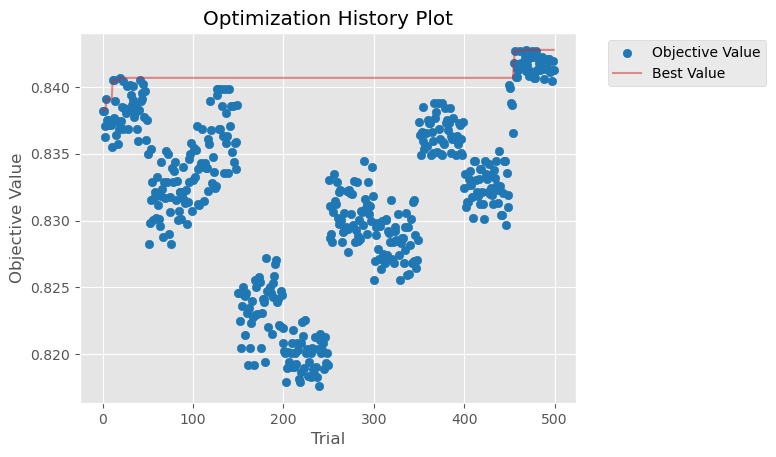

In [36]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_rf)

In [37]:
detailed_objective_rf_CV(study_rf.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,TP,167.300000,6.254776
1,TN,87.300000,3.233505
2,FP,26.100000,4.954235
3,FN,16.400000,3.438346
4,Accuracy,0.856951,0.022401
5,Precision,0.865046,0.025351
6,Sensitivity,0.910601,0.019079
7,Specificity,0.770750,0.036690
8,F1 score,0.887078,0.018965
9,F1 score (weighted),0.855573,0.022796


In [38]:
mat_met_rf_test['ave'] = mat_met_rf_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_rf_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave
0,TP,330.000000,320.000000,333.000000,329.000000,337.000000,328.000000,332.000000,332.000000,333.000000,330.000000,330.400000
1,TN,170.000000,184.000000,170.000000,175.000000,178.000000,178.000000,166.000000,174.000000,180.000000,161.000000,173.600000
2,FP,57.000000,53.000000,59.000000,63.000000,60.000000,56.000000,47.000000,54.000000,49.000000,66.000000,56.400000
3,FN,38.000000,38.000000,33.000000,28.000000,20.000000,33.000000,50.000000,35.000000,33.000000,38.000000,34.600000
4,Accuracy,0.840336,0.847059,0.845378,0.847059,0.865546,0.850420,0.836975,0.850420,0.862185,0.825210,0.847059
5,Precision,0.852713,0.857909,0.849490,0.839286,0.848866,0.854167,0.875989,0.860104,0.871728,0.833333,0.854358
6,Sensitivity,0.896739,0.893855,0.909836,0.921569,0.943978,0.908587,0.869110,0.904632,0.909836,0.896739,0.905488
7,Specificity,0.748900,0.776400,0.742400,0.735300,0.747900,0.760700,0.779300,0.763200,0.786000,0.709300,0.754940
8,F1 score,0.874172,0.875513,0.878628,0.878505,0.893899,0.880537,0.872536,0.881806,0.890374,0.863874,0.878984
9,F1 score (weighted),0.838858,0.846129,0.843377,0.844563,0.862945,0.848864,0.837223,0.849056,0.861164,0.822669,0.845485


In [39]:
#change to fit into these X values 

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)



Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_rf=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_rf = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=1121218, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )
        optimizedCV_rf.fit(X_train,
                          y_train, 
                          
                  )
        #print(test_idx)
        y_pred_optimized_rf = optimizedCV_rf.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_rf': y_pred_optimized_rf } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
   
        conf_matrix = confusion_matrix(y_test, y_pred_optimized_rf)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
    
        Accuracy_outer.append(accuracy_score(y_test, y_pred_optimized_rf))
        Precision_outer.append(precision_score(y_test, y_pred_optimized_rf))
        Sensitivity_outer.append(recall_score(y_test, y_pred_optimized_rf))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test, y_pred_optimized_rf))
        f1_scores_W_outer.append(f1_score(y_test, y_pred_optimized_rf, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test, y_pred_optimized_rf, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test, y_pred_optimized_rf))
        MCC_outer.append(matthews_corrcoef(y_test, y_pred_optimized_rf))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test, y_pred_optimized_rf))
    data_rf['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_rf['y_test' + str(i)] = data_inner['y_test']
    data_rf['y_pred_rf' + str(i)] = data_inner['y_pred_rf']
   # data_rf['correct' + str(i)] = correct_value
   # data_rf['pred' + str(i)] = y_pred_optimized_rf

mat_met_optimized_rf = pd.DataFrame({'Metric':['Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [ np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 

mat_met_optimized_rf


,Metric,Value (average),Value (std)
0,Accuracy,0.855131,0.018239
1,Precision,0.862623,0.021765
2,Sensitivity,0.911342,0.020318
3,Specificity,0.764104,0.040967
4,F1 score,0.886051,0.014395
5,F1 score (weighted),0.853555,0.018668
6,F1 score (macro),0.843254,0.020481
7,Balanced Accuracy,0.837727,0.021568
8,MCC,0.689867,0.040502
9,NPV,0.842104,0.032700


In [40]:
#cross valide using this optimized RF 
rf_baseline_CVscore = cross_val_score(rf_clf, X, Y, cv=10, scoring="f1_macro")
#rf_opt_testSet_score = cross_val_score(optimized_rf, X, Y, cv=10, scoring="f1_macro")
rf_opt_CVscore = cross_val_score(optimizedCV_rf, X, Y, cv=10, scoring="f1_macro")
print("RF baseline model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(rf_baseline_CVscore), np.std(rf_baseline_CVscore, ddof=1)))
#print("RF optimized model (tested on Y_te) f1_score %0.4f with a standard deviation of %0.4f" % (rf_opt_testSet_score.mean(), rf_opt_testSet_score.std()))
print("RF optimized model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(rf_opt_CVscore), np.std(rf_opt_CVscore, ddof=1)))

RF baseline model f1_score 0.8493 with a standard deviation of 0.0152
RF optimized model f1_score 0.8468 with a standard deviation of 0.0170


In [41]:
# save the modesls, both the one with optimized hyperparameters and the initial one
joblib.dump(rf_clf, "OUTPUT/rf_clf.joblib")
joblib.dump(optimizedCV_rf, "OUTPUT/optimizedCV_rf_clf.joblib")

['OUTPUT/optimizedCV_rf_clf.joblib']

## LGBMclassifier

In [42]:
%%time

TP=np.empty(10)
TN = np.empty(10)
FP= np.empty(10)
FN= np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W=np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        
        lgbm_clf = lgbm.LGBMClassifier(
        objective="binary",
        random_state=1121218,
        #n_estimators=150,
        boosting_type ="gbdt",  # default histogram binning of LGBM,
        n_jobs=16,
        #min_child_samples = 15,
        subsample=0.8, # also called bagging_fraction
        subsample_freq=10,
     
           )


        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_clf.fit(
                    X_train,
                    y_train,
                    eval_set=eval_set,
                    eval_metric="logloss",
                    #early_stopping_rounds=150,
                    verbose=False,
                    )

        y_pred = lgbm_clf.predict(X_test) 
        
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test, y_pred)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


mat_met_lgbm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
print(mat_met_lgbm)

                 Metric  Value (average)  Value (std)
0                    TP       163.100000     7.030884
1                    TN        86.700000     2.869379
2                    FP        26.700000     5.271517
3                    FN        20.600000     4.550946
4              Accuracy         0.840793     0.027458
5             Precision         0.859203     0.028214
6           Sensitivity         0.887707     0.025231
7           Specificity         0.765640     0.038518
8              F1 score         0.873049     0.023727
9   F1 score (weighted)         0.839888     0.027627
10     F1 score (macro)         0.829649     0.027813
11    Balanced Accuracy         0.826671     0.027792
12                  MCC         0.660645     0.054975
13                  NPV         0.808880     0.035126
14              ROC_AUC         0.826671     0.027792
CPU times: user 31.5 s, sys: 112 ms, total: 31.6 s
Wall time: 2.11 s


In [43]:
import optuna  

def objective_lgbm_CV(trial, X, Y, Y_class):
    param_grid = {
        #"device_type": trial.suggestegorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_bin": trial.suggest_int("max_bin", 150, 300),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"lambda_l1": trial.suggest_float("lambda_l1", 0, 0.001),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1.0,100),
        "num_leaves": trial.suggest_int("num_leaves", 30, 750),
        #"min_child_samples": trial.suggest_int("min_child_samples", 15, 100),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6,1),
        #"bagging_freq": trial.suggestegorical("bagging_freq", [1]),
        }
  
    
    
    
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        lgbm_model = lgbm.LGBMClassifier(objective="binary", 
                                            random_state=1121218, 
                                            boosting_type ="gbdt", 
                                            **param_grid, n_jobs=16,
                                            subsample=0.8, # also called bagging_fraction
                                            subsample_freq=10,
                                         )
    
        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        y_pred = lgbm_model.predict(X_test)
        cv_scores[idx] = f1_score(y_test, y_pred, average="macro")
       
        
    return np.mean(cv_scores)

In [44]:
#this is basically inner set parameters
def detailed_objective_lgbm_cv(trial, X, Y, Y_class):
    param_grid = {
        #"device_type": trial.suggestegorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_bin": trial.suggest_int("max_bin", 150, 300),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"lambda_l1": trial.suggest_float("lambda_l1", 0, 0.001),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1.0,100),
        "num_leaves": trial.suggest_int("num_leaves", 30, 750),
        #"min_child_samples": trial.suggest_int("min_child_samples", 15, 100),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6,1),
        #"bagging_freq": trial.suggestegorical("bagging_freq", [1]),
        
    }
    
    
  
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M =np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        lgbm_model = lgbm.LGBMClassifier(objective="binary", 
                                            random_state=1121218, 
                                            boosting_type ="gbdt", 
                                            **param_grid, n_jobs=16,
                                            subsample=0.8, # also called bagging_fraction
                                            subsample_freq=10,
                                         )
    
        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        
        y_pred = lgbm_model.predict(X_test)
        
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test, y_pred)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    print(mat_met)

In [45]:
#Execute optuna and set hyperparameters
study_lgbm = optuna.create_study(direction='maximize', study_name="LGBMClassifier")
func_lgbm_0 = lambda trial: objective_lgbm_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_lgbm.optimize(func_lgbm_0, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 16:35:30,167] A new study created in memory with name: LGBMClassifier
[I 2023-12-04 16:35:33,647] Trial 0 finished with value: 0.8180666193942565 and parameters: {'n_estimators': 555, 'learning_rate': 0.01604322072608594, 'max_depth': 5, 'max_bin': 271, 'num_leaves': 326}. Best is trial 0 with value: 0.8180666193942565.
[I 2023-12-04 16:35:36,352] Trial 1 finished with value: 0.7680868517924951 and parameters: {'n_estimators': 650, 'learning_rate': 0.00977564476192363, 'max_depth': 3, 'max_bin': 196, 'num_leaves': 147}. Best is trial 0 with value: 0.8180666193942565.
[I 2023-12-04 16:35:37,802] Trial 2 finished with value: 0.8320797648692204 and parameters: {'n_estimators': 131, 'learning_rate': 0.15597513238311134, 'max_depth': 8, 'max_bin': 239, 'num_leaves': 570}. Best is trial 2 with value: 0.8320797648692204.
[I 2023-12-04 16:35:39,892] Trial 3 finished with value: 0.8396938988659011 and parameters: {'n_estimators': 556, 'learning_rate': 0.1109654657244034, 'max_dept

	Number of trials: 50.0
	Best value (f1_score): 0.8455
	Best params:
		n_estimators: 614
		learning_rate: 0.11855097491368037
		max_depth: 10
		max_bin: 263
		num_leaves: 491


In [46]:
optimized_lgbm_0 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )
                                         
    
eval_set = [(X_testSet0, Y_testSet0)]
optimized_lgbm_0.fit(X_trainSet0,
                Y_trainSet0,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )

#predict        
y_pred_lgbm_0 = optimized_lgbm_0.predict(X_testSet0)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0, y_pred_lgbm_0)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0, y_pred_lgbm_0)
Precision = precision_score(Y_testSet0, y_pred_lgbm_0)
Sensitivity = recall_score(Y_testSet0, y_pred_lgbm_0)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0, y_pred_lgbm_0)      
f1_scores_W = f1_score(Y_testSet0, y_pred_lgbm_0, average="weighted")
f1_scores_M = f1_score(Y_testSet0, y_pred_lgbm_0, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0, y_pred_lgbm_0)
MCC = matthews_corrcoef(Y_testSet0, y_pred_lgbm_0)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0, y_pred_lgbm_0)


mat_met_lgbm_test = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
    
print(mat_met_lgbm_test)



                 Metric        Set0
0                    TP  320.000000
1                    TN  170.000000
2                    FP   57.000000
3                    FN   48.000000
4              Accuracy    0.823529
5             Precision    0.848806
6           Sensitivity    0.869565
7           Specificity    0.748900
8              F1 score    0.859060
9   F1 score (weighted)    0.822811
10     F1 score (macro)    0.811553
11    Balanced Accuracy    0.809232
12                  MCC    0.623523
13                  NPV    0.779800
14              ROC_AUC    0.809232


In [47]:
#Execute optuna and set hyperparameters

func_lgbm_1 = lambda trial: objective_lgbm_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_lgbm.optimize(func_lgbm_1, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 16:37:05,752] Trial 50 finished with value: 0.8326985363371546 and parameters: {'n_estimators': 474, 'learning_rate': 0.11232660653472355, 'max_depth': 10, 'max_bin': 275, 'num_leaves': 307}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:37:07,466] Trial 51 finished with value: 0.830986403276835 and parameters: {'n_estimators': 678, 'learning_rate': 0.13910172109308172, 'max_depth': 10, 'max_bin': 267, 'num_leaves': 586}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:37:09,301] Trial 52 finished with value: 0.83188373025879 and parameters: {'n_estimators': 611, 'learning_rate': 0.13575642969109664, 'max_depth': 11, 'max_bin': 240, 'num_leaves': 545}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:37:11,006] Trial 53 finished with value: 0.8319291535373292 and parameters: {'n_estimators': 637, 'learning_rate': 0.14919381504167228, 'max_depth': 11, 'max_bin': 294, 'num_leaves': 650}. Best is trial 23 with value: 0.8

	Number of trials: 100.0
	Best value (f1_score): 0.8455
	Best params:
		n_estimators: 614
		learning_rate: 0.11855097491368037
		max_depth: 10
		max_bin: 263
		num_leaves: 491


In [48]:
optimized_lgbm_1 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )
    
eval_set = [(X_testSet1, Y_testSet1)]
optimized_lgbm_1.fit(X_trainSet1,
                Y_trainSet1,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )

#predict        
y_pred_lgbm_1 = optimized_lgbm_1.predict(X_testSet1)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1, y_pred_lgbm_1)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1, y_pred_lgbm_1)
Precision = precision_score(Y_testSet1, y_pred_lgbm_1)
Sensitivity = recall_score(Y_testSet1, y_pred_lgbm_1)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1, y_pred_lgbm_1)      
f1_scores_W = f1_score(Y_testSet1, y_pred_lgbm_1, average="weighted")
f1_scores_M = f1_score(Y_testSet1, y_pred_lgbm_1, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1, y_pred_lgbm_1)
MCC = matthews_corrcoef(Y_testSet1, y_pred_lgbm_1)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1, y_pred_lgbm_1)


set1 = pd.DataFrame({ 'Set1':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set1'] =set1
print(mat_met_lgbm_test)


                 Metric        Set0        Set1
0                    TP  320.000000  314.000000
1                    TN  170.000000  188.000000
2                    FP   57.000000   49.000000
3                    FN   48.000000   44.000000
4              Accuracy    0.823529    0.843697
5             Precision    0.848806    0.865014
6           Sensitivity    0.869565    0.877095
7           Specificity    0.748900    0.793200
8              F1 score    0.859060    0.871012
9   F1 score (weighted)    0.822811    0.843406
10     F1 score (macro)    0.811553    0.836359
11    Balanced Accuracy    0.809232    0.835172
12                  MCC    0.623523    0.672847
13                  NPV    0.779800    0.810300
14              ROC_AUC    0.809232    0.835172


In [49]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_2 = lambda trial: objective_lgbm_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_lgbm.optimize(func_lgbm_2, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 16:38:33,723] Trial 100 finished with value: 0.8332097358592241 and parameters: {'n_estimators': 685, 'learning_rate': 0.09554604139082454, 'max_depth': 11, 'max_bin': 265, 'num_leaves': 449}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:38:35,379] Trial 101 finished with value: 0.8302633127582004 and parameters: {'n_estimators': 552, 'learning_rate': 0.11155171727976343, 'max_depth': 10, 'max_bin': 248, 'num_leaves': 471}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:38:36,944] Trial 102 finished with value: 0.8256203214822785 and parameters: {'n_estimators': 520, 'learning_rate': 0.10268785353646916, 'max_depth': 11, 'max_bin': 255, 'num_leaves': 183}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:38:38,687] Trial 103 finished with value: 0.8300184703057241 and parameters: {'n_estimators': 599, 'learning_rate': 0.128976472339857, 'max_depth': 11, 'max_bin': 245, 'num_leaves': 590}. Best is trial 23 with value

	Number of trials: 150.0
	Best value (f1_score): 0.8455
	Best params:
		n_estimators: 614
		learning_rate: 0.11855097491368037
		max_depth: 10
		max_bin: 263
		num_leaves: 491


In [50]:
optimized_lgbm_2 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet2, Y_testSet2)]
optimized_lgbm_2.fit(X_trainSet2,
                Y_trainSet2,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_2 = optimized_lgbm_2.predict(X_testSet2)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2, y_pred_lgbm_2)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2, y_pred_lgbm_2)
Precision = precision_score(Y_testSet2, y_pred_lgbm_2)
Sensitivity = recall_score(Y_testSet2, y_pred_lgbm_2)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2, y_pred_lgbm_2)      
f1_scores_W = f1_score(Y_testSet2, y_pred_lgbm_2, average="weighted")
f1_scores_M = f1_score(Y_testSet2, y_pred_lgbm_2, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2, y_pred_lgbm_2)
MCC = matthews_corrcoef(Y_testSet2, y_pred_lgbm_2)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2, y_pred_lgbm_2)


Set2 = pd.DataFrame({ 'Set2':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set2'] = Set2
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2
0                    TP  320.000000  314.000000  323.000000
1                    TN  170.000000  188.000000  174.000000
2                    FP   57.000000   49.000000   55.000000
3                    FN   48.000000   44.000000   43.000000
4              Accuracy    0.823529    0.843697    0.835294
5             Precision    0.848806    0.865014    0.854497
6           Sensitivity    0.869565    0.877095    0.882514
7           Specificity    0.748900    0.793200    0.759800
8              F1 score    0.859060    0.871012    0.868280
9   F1 score (weighted)    0.822811    0.843406    0.834407
10     F1 score (macro)    0.811553    0.836359    0.824274
11    Balanced Accuracy    0.809232    0.835172    0.821169
12                  MCC    0.623523    0.672847    0.649302
13                  NPV    0.779800    0.810300    0.801800
14              ROC_AUC    0.809232    0.835172    0.821169


In [51]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_3 = lambda trial: objective_lgbm_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_lgbm.optimize(func_lgbm_3, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 16:39:57,709] Trial 150 finished with value: 0.8295897135977197 and parameters: {'n_estimators': 515, 'learning_rate': 0.09961682961448037, 'max_depth': 11, 'max_bin': 274, 'num_leaves': 511}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:39:59,068] Trial 151 finished with value: 0.8288743868610364 and parameters: {'n_estimators': 872, 'learning_rate': 0.1273795199202139, 'max_depth': 10, 'max_bin': 152, 'num_leaves': 52}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:40:00,628] Trial 152 finished with value: 0.8250853220327858 and parameters: {'n_estimators': 854, 'learning_rate': 0.13277893732989338, 'max_depth': 10, 'max_bin': 233, 'num_leaves': 577}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:40:02,182] Trial 153 finished with value: 0.8270832034430384 and parameters: {'n_estimators': 840, 'learning_rate': 0.12396398717656906, 'max_depth': 10, 'max_bin': 265, 'num_leaves': 62}. Best is trial 23 with value:

	Number of trials: 200.0
	Best value (f1_score): 0.8455
	Best params:
		n_estimators: 614
		learning_rate: 0.11855097491368037
		max_depth: 10
		max_bin: 263
		num_leaves: 491


In [52]:
optimized_lgbm_3 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet3, Y_testSet3)]
optimized_lgbm_3.fit(X_trainSet3,
                Y_trainSet3,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_3 = optimized_lgbm_3.predict(X_testSet3)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3, y_pred_lgbm_3)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3, y_pred_lgbm_3)
Precision = precision_score(Y_testSet3, y_pred_lgbm_3)
Sensitivity = recall_score(Y_testSet3, y_pred_lgbm_3)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3, y_pred_lgbm_3)      
f1_scores_W = f1_score(Y_testSet3, y_pred_lgbm_3, average="weighted")
f1_scores_M = f1_score(Y_testSet3, y_pred_lgbm_3, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3, y_pred_lgbm_3)
MCC = matthews_corrcoef(Y_testSet3, y_pred_lgbm_3)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3, y_pred_lgbm_3)


Set3 = pd.DataFrame({ 'Set3':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set3'] = Set3
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3
0                    TP  320.000000  314.000000  323.000000  324.000000
1                    TN  170.000000  188.000000  174.000000  179.000000
2                    FP   57.000000   49.000000   55.000000   59.000000
3                    FN   48.000000   44.000000   43.000000   33.000000
4              Accuracy    0.823529    0.843697    0.835294    0.845378
5             Precision    0.848806    0.865014    0.854497    0.845953
6           Sensitivity    0.869565    0.877095    0.882514    0.907563
7           Specificity    0.748900    0.793200    0.759800    0.752100
8              F1 score    0.859060    0.871012    0.868280    0.875676
9   F1 score (weighted)    0.822811    0.843406    0.834407    0.843628
10     F1 score (macro)    0.811553    0.836359    0.824274    0.835616
11    Balanced Accuracy    0.809232    0.835172    0.821169    0.829832
12                  MCC    0.623523    0.672847    0.649302    0

In [53]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_4 = lambda trial: objective_lgbm_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_lgbm.optimize(func_lgbm_4, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 16:41:25,106] Trial 200 finished with value: 0.8064591212346006 and parameters: {'n_estimators': 538, 'learning_rate': 0.17341484951954542, 'max_depth': 12, 'max_bin': 260, 'num_leaves': 515}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:41:26,672] Trial 201 finished with value: 0.8040715997698143 and parameters: {'n_estimators': 738, 'learning_rate': 0.14753118347823505, 'max_depth': 11, 'max_bin': 242, 'num_leaves': 481}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:41:30,353] Trial 202 finished with value: 0.80883616141404 and parameters: {'n_estimators': 661, 'learning_rate': 0.028217984613787966, 'max_depth': 11, 'max_bin': 248, 'num_leaves': 540}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:41:31,845] Trial 203 finished with value: 0.8022076757628703 and parameters: {'n_estimators': 709, 'learning_rate': 0.15039404501447604, 'max_depth': 11, 'max_bin': 246, 'num_leaves': 519}. Best is trial 23 with valu

	Number of trials: 250.0
	Best value (f1_score): 0.8455
	Best params:
		n_estimators: 614
		learning_rate: 0.11855097491368037
		max_depth: 10
		max_bin: 263
		num_leaves: 491


In [54]:
optimized_lgbm_4 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet4, Y_testSet4)]
optimized_lgbm_4.fit(X_trainSet4,
                Y_trainSet4,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_4 = optimized_lgbm_4.predict(X_testSet4)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4, y_pred_lgbm_4)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4, y_pred_lgbm_4)
Precision = precision_score(Y_testSet4, y_pred_lgbm_4)
Sensitivity = recall_score(Y_testSet4, y_pred_lgbm_4)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4, y_pred_lgbm_4)      
f1_scores_W = f1_score(Y_testSet4, y_pred_lgbm_4, average="weighted")
f1_scores_M = f1_score(Y_testSet4, y_pred_lgbm_4, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4, y_pred_lgbm_4)
MCC = matthews_corrcoef(Y_testSet4, y_pred_lgbm_4)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4, y_pred_lgbm_4)


Set4 = pd.DataFrame({ 'Set4':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set4'] = Set4
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  320.000000  314.000000  323.000000  324.000000   
1                    TN  170.000000  188.000000  174.000000  179.000000   
2                    FP   57.000000   49.000000   55.000000   59.000000   
3                    FN   48.000000   44.000000   43.000000   33.000000   
4              Accuracy    0.823529    0.843697    0.835294    0.845378   
5             Precision    0.848806    0.865014    0.854497    0.845953   
6           Sensitivity    0.869565    0.877095    0.882514    0.907563   
7           Specificity    0.748900    0.793200    0.759800    0.752100   
8              F1 score    0.859060    0.871012    0.868280    0.875676   
9   F1 score (weighted)    0.822811    0.843406    0.834407    0.843628   
10     F1 score (macro)    0.811553    0.836359    0.824274    0.835616   
11    Balanced Accuracy    0.809232    0.835172    0.821169    0.829832   
12                  MCC  

In [55]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_5 = lambda trial: objective_lgbm_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_lgbm.optimize(func_lgbm_5, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 16:42:55,443] Trial 250 finished with value: 0.7977671394521437 and parameters: {'n_estimators': 739, 'learning_rate': 0.002685262019634052, 'max_depth': 11, 'max_bin': 177, 'num_leaves': 275}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:42:57,183] Trial 251 finished with value: 0.8168893837110405 and parameters: {'n_estimators': 651, 'learning_rate': 0.12383381982440606, 'max_depth': 11, 'max_bin': 242, 'num_leaves': 504}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:42:59,050] Trial 252 finished with value: 0.8287182914806219 and parameters: {'n_estimators': 399, 'learning_rate': 0.10324229622693507, 'max_depth': 12, 'max_bin': 290, 'num_leaves': 129}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:43:00,920] Trial 253 finished with value: 0.8263761520561209 and parameters: {'n_estimators': 552, 'learning_rate': 0.11367522093570051, 'max_depth': 10, 'max_bin': 248, 'num_leaves': 558}. Best is trial 23 with va

	Number of trials: 300.0
	Best value (f1_score): 0.8455
	Best params:
		n_estimators: 614
		learning_rate: 0.11855097491368037
		max_depth: 10
		max_bin: 263
		num_leaves: 491


In [56]:
optimized_lgbm_5 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet5, Y_testSet5)]
optimized_lgbm_5.fit(X_trainSet5,
                Y_trainSet5,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_5 = optimized_lgbm_5.predict(X_testSet5)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5, y_pred_lgbm_5)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5, y_pred_lgbm_5)
Precision = precision_score(Y_testSet5, y_pred_lgbm_5)
Sensitivity = recall_score(Y_testSet5, y_pred_lgbm_5)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5, y_pred_lgbm_5)      
f1_scores_W = f1_score(Y_testSet5, y_pred_lgbm_5, average="weighted")
f1_scores_M = f1_score(Y_testSet5, y_pred_lgbm_5, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5, y_pred_lgbm_5)
MCC = matthews_corrcoef(Y_testSet5, y_pred_lgbm_5)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5, y_pred_lgbm_5)


Set5 = pd.DataFrame({ 'Set5':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set5'] = Set5
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  320.000000  314.000000  323.000000  324.000000   
1                    TN  170.000000  188.000000  174.000000  179.000000   
2                    FP   57.000000   49.000000   55.000000   59.000000   
3                    FN   48.000000   44.000000   43.000000   33.000000   
4              Accuracy    0.823529    0.843697    0.835294    0.845378   
5             Precision    0.848806    0.865014    0.854497    0.845953   
6           Sensitivity    0.869565    0.877095    0.882514    0.907563   
7           Specificity    0.748900    0.793200    0.759800    0.752100   
8              F1 score    0.859060    0.871012    0.868280    0.875676   
9   F1 score (weighted)    0.822811    0.843406    0.834407    0.843628   
10     F1 score (macro)    0.811553    0.836359    0.824274    0.835616   
11    Balanced Accuracy    0.809232    0.835172    0.821169    0.829832   
12                  MCC  

In [57]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_6 = lambda trial: objective_lgbm_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_lgbm.optimize(func_lgbm_6, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.6f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 16:44:25,653] Trial 300 finished with value: 0.8237174739427718 and parameters: {'n_estimators': 383, 'learning_rate': 0.12708733939901687, 'max_depth': 11, 'max_bin': 293, 'num_leaves': 540}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:44:27,576] Trial 301 finished with value: 0.8239320368021245 and parameters: {'n_estimators': 619, 'learning_rate': 0.11574731908665219, 'max_depth': 10, 'max_bin': 216, 'num_leaves': 565}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:44:30,060] Trial 302 finished with value: 0.8267666643517433 and parameters: {'n_estimators': 534, 'learning_rate': 0.09510405237243047, 'max_depth': 12, 'max_bin': 279, 'num_leaves': 600}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:44:31,928] Trial 303 finished with value: 0.8188093219058169 and parameters: {'n_estimators': 494, 'learning_rate': 0.1300168905861699, 'max_depth': 9, 'max_bin': 227, 'num_leaves': 519}. Best is trial 23 with value

	Number of trials: 350.0
	Best value (f1_score): 0.845465
	Best params:
		n_estimators: 614
		learning_rate: 0.11855097491368037
		max_depth: 10
		max_bin: 263
		num_leaves: 491


In [58]:
optimized_lgbm_6 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet6, Y_testSet6)]
optimized_lgbm_6.fit(X_trainSet6,
                Y_trainSet6,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_6 = optimized_lgbm_6.predict(X_testSet6)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6, y_pred_lgbm_6)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6, y_pred_lgbm_6)
Precision = precision_score(Y_testSet6, y_pred_lgbm_6)
Sensitivity = recall_score(Y_testSet6, y_pred_lgbm_6)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6, y_pred_lgbm_6)      
f1_scores_W = f1_score(Y_testSet6, y_pred_lgbm_6, average="weighted")
f1_scores_M = f1_score(Y_testSet6, y_pred_lgbm_6, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6, y_pred_lgbm_6)
MCC = matthews_corrcoef(Y_testSet6, y_pred_lgbm_6)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6, y_pred_lgbm_6)


Set6 = pd.DataFrame({ 'Set6':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set6'] = Set6
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  320.000000  314.000000  323.000000  324.000000   
1                    TN  170.000000  188.000000  174.000000  179.000000   
2                    FP   57.000000   49.000000   55.000000   59.000000   
3                    FN   48.000000   44.000000   43.000000   33.000000   
4              Accuracy    0.823529    0.843697    0.835294    0.845378   
5             Precision    0.848806    0.865014    0.854497    0.845953   
6           Sensitivity    0.869565    0.877095    0.882514    0.907563   
7           Specificity    0.748900    0.793200    0.759800    0.752100   
8              F1 score    0.859060    0.871012    0.868280    0.875676   
9   F1 score (weighted)    0.822811    0.843406    0.834407    0.843628   
10     F1 score (macro)    0.811553    0.836359    0.824274    0.835616   
11    Balanced Accuracy    0.809232    0.835172    0.821169    0.829832   
12                  MCC  

In [59]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_7 = lambda trial: objective_lgbm_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_lgbm.optimize(func_lgbm_7, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.7f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 16:45:56,821] Trial 350 finished with value: 0.8270006967671566 and parameters: {'n_estimators': 367, 'learning_rate': 0.12466295132900364, 'max_depth': 10, 'max_bin': 172, 'num_leaves': 102}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:46:03,802] Trial 351 finished with value: 0.8312503595286325 and parameters: {'n_estimators': 627, 'learning_rate': 0.012054521877515073, 'max_depth': 12, 'max_bin': 239, 'num_leaves': 195}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:46:05,921] Trial 352 finished with value: 0.833931304846088 and parameters: {'n_estimators': 885, 'learning_rate': 0.08779661507780165, 'max_depth': 12, 'max_bin': 293, 'num_leaves': 580}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:46:07,586] Trial 353 finished with value: 0.8277290284564689 and parameters: {'n_estimators': 503, 'learning_rate': 0.11028917946812614, 'max_depth': 9, 'max_bin': 266, 'num_leaves': 511}. Best is trial 23 with valu

	Number of trials: 400.0
	Best value (f1_score): 0.8454651
	Best params:
		n_estimators: 614
		learning_rate: 0.11855097491368037
		max_depth: 10
		max_bin: 263
		num_leaves: 491


In [60]:
optimized_lgbm_7 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet7, Y_testSet7)]
optimized_lgbm_7.fit(X_trainSet7,
                Y_trainSet7,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_7 = optimized_lgbm_7.predict(X_testSet7)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7, y_pred_lgbm_7)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7, y_pred_lgbm_7)
Precision = precision_score(Y_testSet7, y_pred_lgbm_7)
Sensitivity = recall_score(Y_testSet7, y_pred_lgbm_7)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7, y_pred_lgbm_7)      
f1_scores_W = f1_score(Y_testSet7, y_pred_lgbm_7, average="weighted")
f1_scores_M = f1_score(Y_testSet7, y_pred_lgbm_7, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7, y_pred_lgbm_7)
MCC = matthews_corrcoef(Y_testSet7, y_pred_lgbm_7)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7, y_pred_lgbm_7)


Set7 = pd.DataFrame({ 'Set7':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set7'] = Set7
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  320.000000  314.000000  323.000000  324.000000   
1                    TN  170.000000  188.000000  174.000000  179.000000   
2                    FP   57.000000   49.000000   55.000000   59.000000   
3                    FN   48.000000   44.000000   43.000000   33.000000   
4              Accuracy    0.823529    0.843697    0.835294    0.845378   
5             Precision    0.848806    0.865014    0.854497    0.845953   
6           Sensitivity    0.869565    0.877095    0.882514    0.907563   
7           Specificity    0.748900    0.793200    0.759800    0.752100   
8              F1 score    0.859060    0.871012    0.868280    0.875676   
9   F1 score (weighted)    0.822811    0.843406    0.834407    0.843628   
10     F1 score (macro)    0.811553    0.836359    0.824274    0.835616   
11    Balanced Accuracy    0.809232    0.835172    0.821169    0.829832   
12                  MCC  

In [61]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_8 = lambda trial: objective_lgbm_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_lgbm.optimize(func_lgbm_8, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.8f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 16:47:31,046] Trial 400 finished with value: 0.8235504109062297 and parameters: {'n_estimators': 624, 'learning_rate': 0.13104115359869675, 'max_depth': 11, 'max_bin': 290, 'num_leaves': 536}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:47:33,074] Trial 401 finished with value: 0.8209162469851794 and parameters: {'n_estimators': 611, 'learning_rate': 0.12192241245288812, 'max_depth': 12, 'max_bin': 247, 'num_leaves': 573}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:47:34,226] Trial 402 finished with value: 0.8133731836019769 and parameters: {'n_estimators': 776, 'learning_rate': 0.1536249939214529, 'max_depth': 5, 'max_bin': 266, 'num_leaves': 600}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:47:42,385] Trial 403 finished with value: 0.7175415169006369 and parameters: {'n_estimators': 436, 'learning_rate': 0.0013232726690461938, 'max_depth': 10, 'max_bin': 275, 'num_leaves': 482}. Best is trial 23 with val

	Number of trials: 450.0
	Best value (f1_score): 0.84546514
	Best params:
		n_estimators: 614
		learning_rate: 0.11855097491368037
		max_depth: 10
		max_bin: 263
		num_leaves: 491


In [62]:
optimized_lgbm_8 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet8, Y_testSet8)]
optimized_lgbm_8.fit(X_trainSet8,
                Y_trainSet8,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_8 = optimized_lgbm_8.predict(X_testSet8)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8, y_pred_lgbm_8)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8, y_pred_lgbm_8)
Precision = precision_score(Y_testSet8, y_pred_lgbm_8)
Sensitivity = recall_score(Y_testSet8, y_pred_lgbm_8)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8, y_pred_lgbm_8)      
f1_scores_W = f1_score(Y_testSet8, y_pred_lgbm_8, average="weighted")
f1_scores_M = f1_score(Y_testSet8, y_pred_lgbm_8, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8, y_pred_lgbm_8)
MCC = matthews_corrcoef(Y_testSet8, y_pred_lgbm_8)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8, y_pred_lgbm_8)


Set8 = pd.DataFrame({ 'Set8':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set8'] = Set8
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  320.000000  314.000000  323.000000  324.000000   
1                    TN  170.000000  188.000000  174.000000  179.000000   
2                    FP   57.000000   49.000000   55.000000   59.000000   
3                    FN   48.000000   44.000000   43.000000   33.000000   
4              Accuracy    0.823529    0.843697    0.835294    0.845378   
5             Precision    0.848806    0.865014    0.854497    0.845953   
6           Sensitivity    0.869565    0.877095    0.882514    0.907563   
7           Specificity    0.748900    0.793200    0.759800    0.752100   
8              F1 score    0.859060    0.871012    0.868280    0.875676   
9   F1 score (weighted)    0.822811    0.843406    0.834407    0.843628   
10     F1 score (macro)    0.811553    0.836359    0.824274    0.835616   
11    Balanced Accuracy    0.809232    0.835172    0.821169    0.829832   
12                  MCC  

In [63]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_9 = lambda trial: objective_lgbm_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_lgbm.optimize(func_lgbm_9, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.9f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 16:49:18,195] Trial 450 finished with value: 0.8363728574744167 and parameters: {'n_estimators': 503, 'learning_rate': 0.07911136356372417, 'max_depth': 11, 'max_bin': 270, 'num_leaves': 534}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:49:19,660] Trial 451 finished with value: 0.8326318422467421 and parameters: {'n_estimators': 828, 'learning_rate': 0.19711530165804014, 'max_depth': 10, 'max_bin': 243, 'num_leaves': 352}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:49:21,498] Trial 452 finished with value: 0.8365462735217337 and parameters: {'n_estimators': 637, 'learning_rate': 0.10922791886088676, 'max_depth': 10, 'max_bin': 282, 'num_leaves': 469}. Best is trial 23 with value: 0.8454651418857668.
[I 2023-12-04 16:49:23,279] Trial 453 finished with value: 0.8304494872595146 and parameters: {'n_estimators': 681, 'learning_rate': 0.1223853855064141, 'max_depth': 11, 'max_bin': 220, 'num_leaves': 489}. Best is trial 23 with valu

	Number of trials: 500.0
	Best value (f1_score): 0.845465142
	Best params:
		n_estimators: 614
		learning_rate: 0.11855097491368037
		max_depth: 10
		max_bin: 263
		num_leaves: 491


In [64]:
optimized_lgbm_9 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet9, Y_testSet9)]
optimized_lgbm_9.fit(X_trainSet9,
                Y_trainSet9,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_9 = optimized_lgbm_9.predict(X_testSet9)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9, y_pred_lgbm_9)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9, y_pred_lgbm_9)
Precision = precision_score(Y_testSet9, y_pred_lgbm_9)
Sensitivity = recall_score(Y_testSet9, y_pred_lgbm_9)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9, y_pred_lgbm_9)      
f1_scores_W = f1_score(Y_testSet9, y_pred_lgbm_9, average="weighted")
f1_scores_M = f1_score(Y_testSet9, y_pred_lgbm_9, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9, y_pred_lgbm_9)
MCC = matthews_corrcoef(Y_testSet9, y_pred_lgbm_9)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9, y_pred_lgbm_9)


Set9 = pd.DataFrame({ 'Set9':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set9'] = Set9
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  320.000000  314.000000  323.000000  324.000000   
1                    TN  170.000000  188.000000  174.000000  179.000000   
2                    FP   57.000000   49.000000   55.000000   59.000000   
3                    FN   48.000000   44.000000   43.000000   33.000000   
4              Accuracy    0.823529    0.843697    0.835294    0.845378   
5             Precision    0.848806    0.865014    0.854497    0.845953   
6           Sensitivity    0.869565    0.877095    0.882514    0.907563   
7           Specificity    0.748900    0.793200    0.759800    0.752100   
8              F1 score    0.859060    0.871012    0.868280    0.875676   
9   F1 score (weighted)    0.822811    0.843406    0.834407    0.843628   
10     F1 score (macro)    0.811553    0.836359    0.824274    0.835616   
11    Balanced Accuracy    0.809232    0.835172    0.821169    0.829832   
12                  MCC  

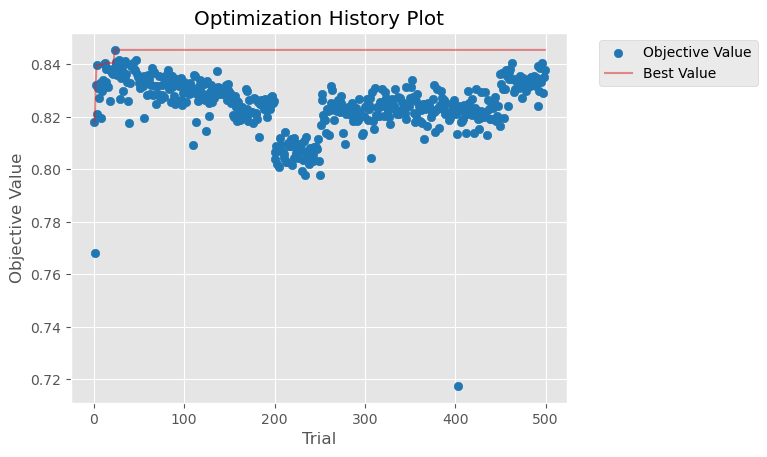

In [65]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_lgbm);

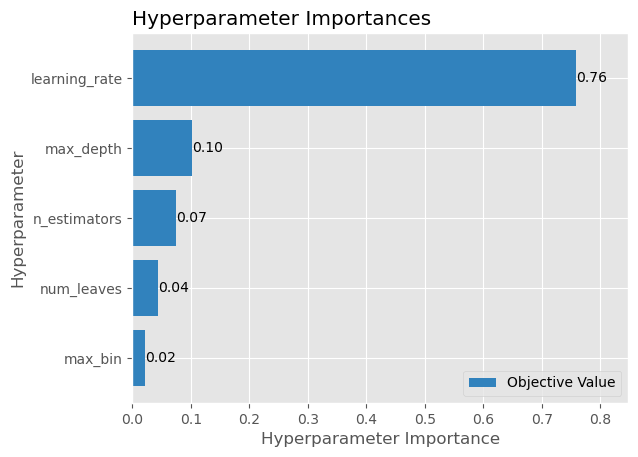

In [66]:
from optuna.visualization.matplotlib import plot_param_importances
plot_param_importances(study_lgbm);

In [67]:
detailed_objective_lgbm_cv(study_lgbm.best_trial, X, Y, Y_class)

                 Metric  Value (average)  Value (std)
0                    TP       163.200000     6.828047
1                    TN        87.300000     3.465705
2                    FP        26.100000     4.886489
3                    FN        20.500000     4.766783
4              Accuracy         0.843152     0.026982
5             Precision         0.862012     0.026301
6           Sensitivity         0.888320     0.026061
7           Specificity         0.770690     0.037053
8              F1 score         0.874802     0.023023
9   F1 score (weighted)         0.842350     0.027035
10     F1 score (macro)         0.832284     0.027614
11    Balanced Accuracy         0.829503     0.027499
12                  MCC         0.665776     0.055001
13                  NPV         0.810660     0.037843
14              ROC_AUC         0.829503     0.027499


In [68]:
#Evaluations metrics on the test sets
mat_met_lgbm_test['ave'] = mat_met_lgbm_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_lgbm_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave
0,TP,320.000000,314.000000,323.000000,324.000000,328.000000,322.000000,336.000000,328.000000,324.000000,324.000000,324.300000
1,TN,170.000000,188.000000,174.000000,179.000000,171.000000,176.000000,169.000000,183.000000,178.000000,158.000000,174.600000
2,FP,57.000000,49.000000,55.000000,59.000000,67.000000,58.000000,44.000000,45.000000,51.000000,69.000000,55.400000
3,FN,48.000000,44.000000,43.000000,33.000000,29.000000,39.000000,46.000000,39.000000,42.000000,44.000000,40.700000
4,Accuracy,0.823529,0.843697,0.835294,0.845378,0.838655,0.836975,0.848739,0.858824,0.843697,0.810084,0.838487
5,Precision,0.848806,0.865014,0.854497,0.845953,0.830380,0.847368,0.884211,0.879357,0.864000,0.824427,0.854401
6,Sensitivity,0.869565,0.877095,0.882514,0.907563,0.918768,0.891967,0.879581,0.893733,0.885246,0.880435,0.888647
7,Specificity,0.748900,0.793200,0.759800,0.752100,0.718500,0.752100,0.793400,0.802600,0.777300,0.696000,0.759390
8,F1 score,0.859060,0.871012,0.868280,0.875676,0.872340,0.869096,0.881890,0.886486,0.874494,0.851511,0.870985
9,F1 score (weighted),0.822811,0.843406,0.834407,0.843628,0.835733,0.835616,0.848894,0.858455,0.843080,0.807670,0.837370


In [69]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)


Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_lgbm=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_lgbm = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


        #learn
        eval_set = [(X_test, y_test)]
        optimizedCV_lgbm.fit(X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
                          
                  
        #print(test_idx)
        y_pred_optimized_lgbm = optimizedCV_lgbm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_lgbm': y_pred_optimized_lgbm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        conf_matrix = confusion_matrix(y_test, y_pred_optimized_lgbm)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
       
        Accuracy_outer.append(accuracy_score(y_test, y_pred_optimized_lgbm))
        Precision_outer.append(precision_score(y_test, y_pred_optimized_lgbm))
        Sensitivity_outer.append(recall_score(y_test, y_pred_optimized_lgbm))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test, y_pred_optimized_lgbm))
        f1_scores_W_outer.append(f1_score(y_test, y_pred_optimized_lgbm, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test, y_pred_optimized_lgbm, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test, y_pred_optimized_lgbm))
        MCC_outer.append(matthews_corrcoef(y_test, y_pred_optimized_lgbm))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test, y_pred_optimized_lgbm))
        
    data_lgbm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_lgbm['y_test' + str(i)] = data_inner['y_test']
    data_lgbm['y_pred_lgbm' + str(i)] = data_inner['y_pred_lgbm']
   # data_lgbm['correct' + str(i)] = correct_value
   # data_lgbm['pred' + str(i)] = y_pred_optimized_lgbm

mat_met_optimized_lgbm = pd.DataFrame({'Metric':['Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [ np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


mat_met_optimized_lgbm


,Metric,Value (average),Value (std)
0,Accuracy,0.846113,0.014913
1,Precision,0.862783,0.021994
2,Sensitivity,0.893734,0.019724
3,Specificity,0.769016,0.038851
4,F1 score,0.877675,0.012538
5,F1 score (weighted),0.845065,0.015234
6,F1 score (macro),0.834757,0.016173
7,Balanced Accuracy,0.831377,0.017700
8,MCC,0.671513,0.032332
9,NPV,0.817710,0.026888


In [70]:
#cross valide using this optimized LightGBM 
fit_params={'early_stopping_rounds': 50, 
        'eval_set': [(X_tr, Y_tr), (X_te, Y_te)],
            'verbose':False,
           }
#cross valide using this optimized LightGBM 
lgbm_baseline_CVscore = cross_val_score(lgbm_clf, X, Y, cv=10, scoring="f1_macro")
#f1_cv_lgbm_opt_testSet = cross_val_score(optimized_lgbm, X, Y, cv=10, scoring="f1_macro")
f1_cv_lgbm_opt = cross_val_score(optimizedCV_lgbm, X, Y, cv=10, scoring="f1_macro", fit_params=fit_params)
print("LightGBM baseline model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(lgbm_baseline_CVscore), np.std(lgbm_baseline_CVscore, ddof=1)))
#print("LightGBM optimized model (tested on Y_te)f1_score %0.4f with a standard deviation of %0.4f" % (f1_cv_lgbm_opt_testSet.mean(), f1_cv_lgbm_opt_testSet.std()))
print("LightGBM optimized model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(f1_cv_lgbm_opt), np.std(f1_cv_lgbm_opt, ddof=1)))

LightGBM baseline model f1_score 0.8342 with a standard deviation of 0.0184
LightGBM optimized model f1_score 0.8315 with a standard deviation of 0.0214


In [71]:
# save the modesls, both the one with optimized hyperparameters and the initial one
joblib.dump(lgbm_clf, "OUTPUT/lgbm_clf.joblib")
joblib.dump(optimizedCV_lgbm, "OUTPUT/optimizedCV_lgbm_clf.joblib") 


['OUTPUT/optimizedCV_lgbm_clf.joblib']

## XGBoost

In [72]:
%%time


TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)


for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    random_state=1121218,
    #n_estimators=10000,  
    tree_method="hist",  # enable histogram binning in XGB
    subsample=0.8, 
    n_jobs=16,
    )
    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_clf.fit(X_train,
                y_train,
    
    eval_set=eval_set,
    eval_metric="logloss",
    early_stopping_rounds=50,
    verbose=False,  # Disable logs
               )

    y_pred = xgb_clf.predict(X_test) 
    
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test, y_pred)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test, y_pred)
    Precision[idx] = precision_score(y_test, y_pred)
    Sensitivity[idx] = recall_score(y_test, y_pred)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test, y_pred)
    f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
    f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
    MCC[idx] = matthews_corrcoef(y_test, y_pred)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    TP       162.100000     6.674162
1                    TN        87.200000     3.047768
2                    FP        26.200000     5.094660
3                    FN        21.600000     4.857983
4              Accuracy         0.839115     0.023233
5             Precision         0.860942     0.026062
6           Sensitivity         0.882369     0.026451
7           Specificity         0.769950     0.037469
8              F1 score         0.871226     0.020480
9   F1 score (weighted)         0.838413     0.023360
10     F1 score (macro)         0.828254     0.023352
11    Balanced Accuracy         0.826161     0.023457
12                  MCC         0.657889     0.045830
13                  NPV         0.802640     0.033501
14              ROC_AUC         0.826161     0.023457
CPU times: user 24.5 s, sys: 164 ms, total: 24.6 s
Wall time: 1.64 s


In [73]:
def objective_xgb_CV(trial, X, Y, Y_class):
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "eta": trial.suggest_float("eta", 1e-6, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 5, 12),  
        "alpha": trial.suggest_float("alpha", 0, 1, step=1e-04),
        "lambda": trial.suggest_float("lambda", 1,40),
        #"alpha": trial.suggest_float("alpha", 0, 1.0),
        #"lambda": trial.suggest_float("lambda", 1e-8, 40.0),
        "max_bin": trial.suggest_int("max_bin", 250, 500),
    }
    
    
    cv_scores=np.empty(10)
    #y_comb=pd.DataFrame()
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=1121218, booster ="gbtree", tree_method='hist',
                                  **param_grid,  n_jobs=16, subsample=0.8, )
    
        eval_set = [(X_test, y_test)]
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            eval_metric="logloss",    
            early_stopping_rounds=50,
            verbose=False)
    
        y_pred = xgb_model.predict(X_test)
        cv_scores[idx] = f1_score(y_test, y_pred, average="macro")
            
    return np.mean(cv_scores)

In [74]:
def detailed_objective_xgb_CV(trial, X, Y, Y_class):
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "eta": trial.suggest_float("eta", 1e-6, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 5, 12),  
        "alpha": trial.suggest_float("alpha", 0, 1, step=1e-04),
        "lambda": trial.suggest_float("lambda", 1,40),
        #"alpha": trial.suggest_float("alpha", 0, 1.0),
        #"lambda": trial.suggest_float("lambda", 1e-8, 40.0),
        "max_bin": trial.suggest_int("max_bin", 250, 500),
    }
    
    
    
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W=np.empty(10)
    f1_scores_M=np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=1121218, booster ="gbtree", tree_method='hist',
                                  **param_grid,  n_jobs=16, subsample=0.8, )
    
        eval_set = [(X_test, y_test)]
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            eval_metric="logloss",    
            early_stopping_rounds=50,
            verbose=False)
        
        y_pred = xgb_model.predict(X_test)
        
       
           
        #calculate parameters
        conf_matrix = confusion_matrix(y_test, y_pred)      
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)

    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
    return (mat_met)   

In [75]:
#Execute optuna and set hyperparameters
study_xgb = optuna.create_study(direction='maximize', study_name="XGBClassifier")
func_xgb_0 = lambda trial: objective_xgb_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_xgb.optimize(func_xgb_0, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 16:51:36,643] A new study created in memory with name: XGBClassifier
[I 2023-12-04 16:51:42,489] Trial 0 finished with value: 0.8355992710495699 and parameters: {'n_estimators': 465, 'eta': 0.06677184097099524, 'max_depth': 12, 'alpha': 0.3049, 'lambda': 16.28975340097403, 'max_bin': 471}. Best is trial 0 with value: 0.8355992710495699.
[I 2023-12-04 16:51:43,611] Trial 1 finished with value: 0.7645871223893292 and parameters: {'n_estimators': 53, 'eta': 0.01908258743303956, 'max_depth': 7, 'alpha': 0.3084, 'lambda': 33.89111737772557, 'max_bin': 452}. Best is trial 0 with value: 0.8355992710495699.
[I 2023-12-04 16:51:49,952] Trial 2 finished with value: 0.8344427182646628 and parameters: {'n_estimators': 254, 'eta': 0.02742122305200364, 'max_depth': 12, 'alpha': 0.031100000000000003, 'lambda': 21.31845262874199, 'max_bin': 458}. Best is trial 0 with value: 0.8355992710495699.
[I 2023-12-04 16:51:57,064] Trial 3 finished with value: 0.8160250315022062 and parameters: {'n

	Number of trials: 50.0
	Best value (f1_score): 0.8425
	Best params:
		n_estimators: 548
		eta: 0.09018534818954298
		max_depth: 12
		alpha: 0.1328
		lambda: 36.36011307197028
		max_bin: 335


In [76]:
#Create an instance with tuned hyperparameters

optimized_xgb_0 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    #learn
eval_set = [(X_testSet0, Y_testSet0)]

optimized_xgb_0.fit(X_trainSet0,Y_trainSet0, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

   
y_pred_xgb_0 = optimized_xgb_0.predict(X_testSet0)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0, y_pred_xgb_0)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0, y_pred_xgb_0)
Precision = precision_score(Y_testSet0, y_pred_xgb_0)
Sensitivity = recall_score(Y_testSet0, y_pred_xgb_0)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0, y_pred_xgb_0)      
f1_scores_W = f1_score(Y_testSet0, y_pred_xgb_0, average="weighted")
f1_scores_M = f1_score(Y_testSet0, y_pred_xgb_0, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0, y_pred_xgb_0)
MCC = matthews_corrcoef(Y_testSet0, y_pred_xgb_0)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0, y_pred_xgb_0)
    

mat_met_xgb_test = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_xgb_test)


                 Metric        Set0
0                    TP  326.000000
1                    TN  169.000000
2                    FP   58.000000
3                    FN   42.000000
4              Accuracy    0.831933
5             Precision    0.848958
6           Sensitivity    0.885870
7           Specificity    0.744500
8              F1 score    0.867021
9   F1 score (weighted)    0.830651
10     F1 score (macro)    0.819355
11    Balanced Accuracy    0.815181
12                  MCC    0.640060
13                  NPV    0.800900
14              ROC_AUC    0.815181


In [77]:
#Execute optuna and set hyperparameters

func_xgb_1 = lambda trial: objective_xgb_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_xgb.optimize(func_xgb_1, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 16:56:59,688] Trial 50 finished with value: 0.831626580178011 and parameters: {'n_estimators': 749, 'eta': 0.08829276781754136, 'max_depth': 12, 'alpha': 0.0054, 'lambda': 32.18680846636148, 'max_bin': 364}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 16:57:05,376] Trial 51 finished with value: 0.8313287419481007 and parameters: {'n_estimators': 339, 'eta': 0.08890751398515609, 'max_depth': 11, 'alpha': 0.1585, 'lambda': 35.357120158605674, 'max_bin': 489}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 16:57:10,684] Trial 52 finished with value: 0.831718226081899 and parameters: {'n_estimators': 385, 'eta': 0.0987183778766157, 'max_depth': 11, 'alpha': 0.20070000000000002, 'lambda': 35.173815580137344, 'max_bin': 419}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 16:57:16,982] Trial 53 finished with value: 0.8326132916086368 and parameters: {'n_estimators': 522, 'eta': 0.09103284635495493, 'max_depth': 11, 'alpha': 0.5

	Number of trials: 100.0
	Best value (f1_score): 0.8425
	Best params:
		n_estimators: 548
		eta: 0.09018534818954298
		max_depth: 12
		alpha: 0.1328
		lambda: 36.36011307197028
		max_bin: 335


In [78]:
optimized_xgb_1 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet1, Y_testSet1)]
optimized_xgb_1.fit(X_trainSet1,Y_trainSet1, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_1 = optimized_xgb_1.predict(X_testSet1)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1, y_pred_xgb_1)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1, y_pred_xgb_1)
Precision = precision_score(Y_testSet1, y_pred_xgb_1)
Sensitivity = recall_score(Y_testSet1, y_pred_xgb_1)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1, y_pred_xgb_1)      
f1_scores_W = f1_score(Y_testSet1, y_pred_xgb_1, average="weighted")
f1_scores_M = f1_score(Y_testSet1, y_pred_xgb_1, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1, y_pred_xgb_1)
MCC = matthews_corrcoef(Y_testSet1, y_pred_xgb_1)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1, y_pred_xgb_1)


set1 = pd.DataFrame({ 'Set1':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set1'] =set1
print(mat_met_xgb_test)


                 Metric        Set0        Set1
0                    TP  326.000000  318.000000
1                    TN  169.000000  186.000000
2                    FP   58.000000   51.000000
3                    FN   42.000000   40.000000
4              Accuracy    0.831933    0.847059
5             Precision    0.848958    0.861789
6           Sensitivity    0.885870    0.888268
7           Specificity    0.744500    0.784800
8              F1 score    0.867021    0.874828
9   F1 score (weighted)    0.830651    0.846399
10     F1 score (macro)    0.819355    0.839142
11    Balanced Accuracy    0.815181    0.836539
12                  MCC    0.640060    0.678913
13                  NPV    0.800900    0.823000
14              ROC_AUC    0.815181    0.836539


In [79]:
#Execute optuna and set hyperparameters
func_xgb_2 = lambda trial: objective_xgb_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_xgb.optimize(func_xgb_2, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 17:01:35,297] Trial 100 finished with value: 0.8339846722786323 and parameters: {'n_estimators': 292, 'eta': 0.08131056651110546, 'max_depth': 11, 'alpha': 0.6858000000000001, 'lambda': 38.029362754973256, 'max_bin': 339}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:01:40,782] Trial 101 finished with value: 0.8337827363692204 and parameters: {'n_estimators': 507, 'eta': 0.09744034964565274, 'max_depth': 12, 'alpha': 0.7166, 'lambda': 35.538607945477004, 'max_bin': 492}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:01:45,900] Trial 102 finished with value: 0.8319923878352364 and parameters: {'n_estimators': 579, 'eta': 0.09999813719585379, 'max_depth': 12, 'alpha': 0.5564, 'lambda': 36.760414132629634, 'max_bin': 487}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:01:50,867] Trial 103 finished with value: 0.8356147966413291 and parameters: {'n_estimators': 547, 'eta': 0.09597917652776401, 'max_depth': 12, 'alph

	Number of trials: 150.0
	Best value (f1_score): 0.8425
	Best params:
		n_estimators: 548
		eta: 0.09018534818954298
		max_depth: 12
		alpha: 0.1328
		lambda: 36.36011307197028
		max_bin: 335


In [80]:
optimized_xgb_2 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet2, Y_testSet2)]
optimized_xgb_2.fit(X_trainSet2,Y_trainSet2, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_2 = optimized_xgb_2.predict(X_testSet2)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2, y_pred_xgb_2)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2, y_pred_xgb_2)
Precision = precision_score(Y_testSet2, y_pred_xgb_2)
Sensitivity = recall_score(Y_testSet2, y_pred_xgb_2)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2, y_pred_xgb_2)      
f1_scores_W = f1_score(Y_testSet2, y_pred_xgb_2, average="weighted")
f1_scores_M = f1_score(Y_testSet2, y_pred_xgb_2, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2, y_pred_xgb_2)
MCC = matthews_corrcoef(Y_testSet2, y_pred_xgb_2)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2, y_pred_xgb_2)


Set2 = pd.DataFrame({ 'Set2':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set2'] =Set2
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2
0                    TP  326.000000  318.000000  325.000000
1                    TN  169.000000  186.000000  175.000000
2                    FP   58.000000   51.000000   54.000000
3                    FN   42.000000   40.000000   41.000000
4              Accuracy    0.831933    0.847059    0.840336
5             Precision    0.848958    0.861789    0.857520
6           Sensitivity    0.885870    0.888268    0.887978
7           Specificity    0.744500    0.784800    0.764200
8              F1 score    0.867021    0.874828    0.872483
9   F1 score (weighted)    0.830651    0.846399    0.839397
10     F1 score (macro)    0.819355    0.839142    0.829500
11    Balanced Accuracy    0.815181    0.836539    0.826085
12                  MCC    0.640060    0.678913    0.659892
13                  NPV    0.800900    0.823000    0.810200
14              ROC_AUC    0.815181    0.836539    0.826085


In [81]:
#Execute optuna and set hyperparameters
func_xgb_3 = lambda trial: objective_xgb_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_xgb.optimize(func_xgb_3, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 17:06:08,170] Trial 150 finished with value: 0.8260513980993751 and parameters: {'n_estimators': 502, 'eta': 0.08746031460470927, 'max_depth': 5, 'alpha': 0.538, 'lambda': 33.63258702149681, 'max_bin': 471}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:06:12,790] Trial 151 finished with value: 0.8318863758140163 and parameters: {'n_estimators': 303, 'eta': 0.09877630514590498, 'max_depth': 11, 'alpha': 0.1689, 'lambda': 36.06638541265984, 'max_bin': 486}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:06:17,795] Trial 152 finished with value: 0.8344938819277997 and parameters: {'n_estimators': 360, 'eta': 0.08931221061152136, 'max_depth': 11, 'alpha': 0.2214, 'lambda': 34.8582488325943, 'max_bin': 462}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:06:22,588] Trial 153 finished with value: 0.8308429087849589 and parameters: {'n_estimators': 262, 'eta': 0.08192413697646124, 'max_depth': 12, 'alpha': 0.137, 'lambda

	Number of trials: 200.0
	Best value (f1_score): 0.8425
	Best params:
		n_estimators: 548
		eta: 0.09018534818954298
		max_depth: 12
		alpha: 0.1328
		lambda: 36.36011307197028
		max_bin: 335


In [82]:
optimized_xgb_3 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet3, Y_testSet3)]
optimized_xgb_3.fit(X_trainSet3,Y_trainSet3, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_3 = optimized_xgb_3.predict(X_testSet3)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3, y_pred_xgb_3)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3, y_pred_xgb_3)
Precision = precision_score(Y_testSet3, y_pred_xgb_3)
Sensitivity = recall_score(Y_testSet3, y_pred_xgb_3)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3, y_pred_xgb_3)      
f1_scores_W = f1_score(Y_testSet3, y_pred_xgb_3, average="weighted")
f1_scores_M = f1_score(Y_testSet3, y_pred_xgb_3, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3, y_pred_xgb_3)
MCC = matthews_corrcoef(Y_testSet3, y_pred_xgb_3)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3, y_pred_xgb_3)


Set3 = pd.DataFrame({ 'Set3':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set3'] =Set3
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3
0                    TP  326.000000  318.000000  325.000000  328.000000
1                    TN  169.000000  186.000000  175.000000  176.000000
2                    FP   58.000000   51.000000   54.000000   62.000000
3                    FN   42.000000   40.000000   41.000000   29.000000
4              Accuracy    0.831933    0.847059    0.840336    0.847059
5             Precision    0.848958    0.861789    0.857520    0.841026
6           Sensitivity    0.885870    0.888268    0.887978    0.918768
7           Specificity    0.744500    0.784800    0.764200    0.739500
8              F1 score    0.867021    0.874828    0.872483    0.878179
9   F1 score (weighted)    0.830651    0.846399    0.839397    0.844741
10     F1 score (macro)    0.819355    0.839142    0.829500    0.836381
11    Balanced Accuracy    0.815181    0.836539    0.826085    0.829132
12                  MCC    0.640060    0.678913    0.659892    0

In [83]:
#Execute optuna and set hyperparameters
func_xgb_4 = lambda trial: objective_xgb_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_xgb.optimize(func_xgb_4, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 17:10:12,851] Trial 200 finished with value: 0.812661180358982 and parameters: {'n_estimators': 382, 'eta': 0.07367615751006926, 'max_depth': 9, 'alpha': 0.0714, 'lambda': 28.332519790865835, 'max_bin': 483}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:10:17,628] Trial 201 finished with value: 0.8147522220179513 and parameters: {'n_estimators': 403, 'eta': 0.0838052059468657, 'max_depth': 9, 'alpha': 0.13290000000000002, 'lambda': 32.48877748132963, 'max_bin': 470}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:10:22,641] Trial 202 finished with value: 0.8137781514723038 and parameters: {'n_estimators': 348, 'eta': 0.08049844103095487, 'max_depth': 9, 'alpha': 0.1817, 'lambda': 34.67873440187455, 'max_bin': 461}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:10:27,473] Trial 203 finished with value: 0.8175248492391265 and parameters: {'n_estimators': 418, 'eta': 0.08682225262520304, 'max_depth': 9, 'alpha': 0.1

	Number of trials: 250.0
	Best value (f1_score): 0.8425
	Best params:
		n_estimators: 548
		eta: 0.09018534818954298
		max_depth: 12
		alpha: 0.1328
		lambda: 36.36011307197028
		max_bin: 335


In [84]:
optimized_xgb_4 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet4, Y_testSet4)]
optimized_xgb_4.fit(X_trainSet4,Y_trainSet4, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_4 = optimized_xgb_4.predict(X_testSet4)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4, y_pred_xgb_4)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4, y_pred_xgb_4)
Precision = precision_score(Y_testSet4, y_pred_xgb_4)
Sensitivity = recall_score(Y_testSet4, y_pred_xgb_4)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4, y_pred_xgb_4)      
f1_scores_W = f1_score(Y_testSet4, y_pred_xgb_4, average="weighted")
f1_scores_M = f1_score(Y_testSet4, y_pred_xgb_4, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4, y_pred_xgb_4)
MCC = matthews_corrcoef(Y_testSet4, y_pred_xgb_4)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4, y_pred_xgb_4)


Set4 = pd.DataFrame({ 'Set4':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set4'] =Set4
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  326.000000  318.000000  325.000000  328.000000   
1                    TN  169.000000  186.000000  175.000000  176.000000   
2                    FP   58.000000   51.000000   54.000000   62.000000   
3                    FN   42.000000   40.000000   41.000000   29.000000   
4              Accuracy    0.831933    0.847059    0.840336    0.847059   
5             Precision    0.848958    0.861789    0.857520    0.841026   
6           Sensitivity    0.885870    0.888268    0.887978    0.918768   
7           Specificity    0.744500    0.784800    0.764200    0.739500   
8              F1 score    0.867021    0.874828    0.872483    0.878179   
9   F1 score (weighted)    0.830651    0.846399    0.839397    0.844741   
10     F1 score (macro)    0.819355    0.839142    0.829500    0.836381   
11    Balanced Accuracy    0.815181    0.836539    0.826085    0.829132   
12                  MCC  

In [85]:
#Execute optuna and set hyperparameters
func_xgb_5 = lambda trial: objective_xgb_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_xgb.optimize(func_xgb_5, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 17:14:10,528] Trial 250 finished with value: 0.8154908024130257 and parameters: {'n_estimators': 343, 'eta': 0.09685802939580654, 'max_depth': 11, 'alpha': 0.498, 'lambda': 33.83122111399256, 'max_bin': 341}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:14:15,115] Trial 251 finished with value: 0.8158073080527253 and parameters: {'n_estimators': 529, 'eta': 0.08337449612489119, 'max_depth': 11, 'alpha': 0.1495, 'lambda': 20.51920400827302, 'max_bin': 478}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:14:20,629] Trial 252 finished with value: 0.8153582000047148 and parameters: {'n_estimators': 478, 'eta': 0.08619797432359255, 'max_depth': 9, 'alpha': 0.4434, 'lambda': 35.67290226035475, 'max_bin': 493}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:14:27,275] Trial 253 finished with value: 0.8133943793076754 and parameters: {'n_estimators': 591, 'eta': 0.06520060249009944, 'max_depth': 12, 'alpha': 0.669, 'lambd

	Number of trials: 300.0
	Best value (f1_score): 0.8425
	Best params:
		n_estimators: 548
		eta: 0.09018534818954298
		max_depth: 12
		alpha: 0.1328
		lambda: 36.36011307197028
		max_bin: 335


In [86]:
optimized_xgb_5 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet5, Y_testSet5)]
optimized_xgb_5.fit(X_trainSet5,Y_trainSet5, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_5 = optimized_xgb_5.predict(X_testSet5)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5, y_pred_xgb_5)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5, y_pred_xgb_5)
Precision = precision_score(Y_testSet5, y_pred_xgb_5)
Sensitivity = recall_score(Y_testSet5, y_pred_xgb_5)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5, y_pred_xgb_5)      
f1_scores_W = f1_score(Y_testSet5, y_pred_xgb_5, average="weighted")
f1_scores_M = f1_score(Y_testSet5, y_pred_xgb_5, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5, y_pred_xgb_5)
MCC = matthews_corrcoef(Y_testSet5, y_pred_xgb_5)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5, y_pred_xgb_5)


Set5 = pd.DataFrame({ 'Set5':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set5'] =Set5
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  326.000000  318.000000  325.000000  328.000000   
1                    TN  169.000000  186.000000  175.000000  176.000000   
2                    FP   58.000000   51.000000   54.000000   62.000000   
3                    FN   42.000000   40.000000   41.000000   29.000000   
4              Accuracy    0.831933    0.847059    0.840336    0.847059   
5             Precision    0.848958    0.861789    0.857520    0.841026   
6           Sensitivity    0.885870    0.888268    0.887978    0.918768   
7           Specificity    0.744500    0.784800    0.764200    0.739500   
8              F1 score    0.867021    0.874828    0.872483    0.878179   
9   F1 score (weighted)    0.830651    0.846399    0.839397    0.844741   
10     F1 score (macro)    0.819355    0.839142    0.829500    0.836381   
11    Balanced Accuracy    0.815181    0.836539    0.826085    0.829132   
12                  MCC  

In [87]:
#Execute optuna and set hyperparameters
func_xgb_6 = lambda trial: objective_xgb_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_xgb.optimize(func_xgb_6, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 17:18:34,496] Trial 300 finished with value: 0.824615994317071 and parameters: {'n_estimators': 344, 'eta': 0.09190914432833001, 'max_depth': 12, 'alpha': 0.5850000000000001, 'lambda': 34.148046047539005, 'max_bin': 388}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:18:41,277] Trial 301 finished with value: 0.8226112475764106 and parameters: {'n_estimators': 378, 'eta': 0.05850394299552108, 'max_depth': 11, 'alpha': 0.1136, 'lambda': 33.06984426641224, 'max_bin': 478}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:18:47,757] Trial 302 finished with value: 0.8200930859920834 and parameters: {'n_estimators': 644, 'eta': 0.07504603217953179, 'max_depth': 11, 'alpha': 0.7541, 'lambda': 36.67485181308939, 'max_bin': 472}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:18:53,113] Trial 303 finished with value: 0.8233962152071905 and parameters: {'n_estimators': 515, 'eta': 0.08432860975807599, 'max_depth': 12, 'alpha':

	Number of trials: 350.0
	Best value (f1_score): 0.8425
	Best params:
		n_estimators: 548
		eta: 0.09018534818954298
		max_depth: 12
		alpha: 0.1328
		lambda: 36.36011307197028
		max_bin: 335


In [88]:
optimized_xgb_6 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet6, Y_testSet6)]
optimized_xgb_6.fit(X_trainSet6,Y_trainSet6, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_6 = optimized_xgb_6.predict(X_testSet6)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6, y_pred_xgb_6)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6, y_pred_xgb_6)
Precision = precision_score(Y_testSet6, y_pred_xgb_6)
Sensitivity = recall_score(Y_testSet6, y_pred_xgb_6)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6, y_pred_xgb_6)      
f1_scores_W = f1_score(Y_testSet6, y_pred_xgb_6, average="weighted")
f1_scores_M = f1_score(Y_testSet6, y_pred_xgb_6, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6, y_pred_xgb_6)
MCC = matthews_corrcoef(Y_testSet6, y_pred_xgb_6)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6, y_pred_xgb_6)


Set6 = pd.DataFrame({ 'Set6':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set6'] =Set6
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  326.000000  318.000000  325.000000  328.000000   
1                    TN  169.000000  186.000000  175.000000  176.000000   
2                    FP   58.000000   51.000000   54.000000   62.000000   
3                    FN   42.000000   40.000000   41.000000   29.000000   
4              Accuracy    0.831933    0.847059    0.840336    0.847059   
5             Precision    0.848958    0.861789    0.857520    0.841026   
6           Sensitivity    0.885870    0.888268    0.887978    0.918768   
7           Specificity    0.744500    0.784800    0.764200    0.739500   
8              F1 score    0.867021    0.874828    0.872483    0.878179   
9   F1 score (weighted)    0.830651    0.846399    0.839397    0.844741   
10     F1 score (macro)    0.819355    0.839142    0.829500    0.836381   
11    Balanced Accuracy    0.815181    0.836539    0.826085    0.829132   
12                  MCC  

In [89]:
#Execute optuna and set hyperparameters
func_xgb_7 = lambda trial: objective_xgb_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_xgb.optimize(func_xgb_7, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 17:23:16,261] Trial 350 finished with value: 0.818371376146346 and parameters: {'n_estimators': 403, 'eta': 0.08856213802152178, 'max_depth': 6, 'alpha': 0.2384, 'lambda': 27.54615929087489, 'max_bin': 444}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:23:20,454] Trial 351 finished with value: 0.8302681342873125 and parameters: {'n_estimators': 382, 'eta': 0.09413532217583322, 'max_depth': 12, 'alpha': 0.4839, 'lambda': 20.072029323105752, 'max_bin': 427}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:23:25,100] Trial 352 finished with value: 0.8210285267231434 and parameters: {'n_estimators': 278, 'eta': 0.08476806435762481, 'max_depth': 8, 'alpha': 0.0975, 'lambda': 38.81618781928249, 'max_bin': 486}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:23:30,985] Trial 353 finished with value: 0.8283727229289299 and parameters: {'n_estimators': 310, 'eta': 0.0707694375691166, 'max_depth': 12, 'alpha': 0.180300000000

	Number of trials: 400.0
	Best value (f1_score): 0.8425
	Best params:
		n_estimators: 548
		eta: 0.09018534818954298
		max_depth: 12
		alpha: 0.1328
		lambda: 36.36011307197028
		max_bin: 335


In [90]:
optimized_xgb_7 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet7, Y_testSet7)]
optimized_xgb_7.fit(X_trainSet7,Y_trainSet7, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_7 = optimized_xgb_7.predict(X_testSet7)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7, y_pred_xgb_7)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7, y_pred_xgb_7)
Precision = precision_score(Y_testSet7, y_pred_xgb_7)
Sensitivity = recall_score(Y_testSet7, y_pred_xgb_7)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7, y_pred_xgb_7)      
f1_scores_W = f1_score(Y_testSet7, y_pred_xgb_7, average="weighted")
f1_scores_M = f1_score(Y_testSet7, y_pred_xgb_7, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7, y_pred_xgb_7)
MCC = matthews_corrcoef(Y_testSet7, y_pred_xgb_7)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7, y_pred_xgb_7)


Set7 = pd.DataFrame({ 'Set7':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set7'] =Set7
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  326.000000  318.000000  325.000000  328.000000   
1                    TN  169.000000  186.000000  175.000000  176.000000   
2                    FP   58.000000   51.000000   54.000000   62.000000   
3                    FN   42.000000   40.000000   41.000000   29.000000   
4              Accuracy    0.831933    0.847059    0.840336    0.847059   
5             Precision    0.848958    0.861789    0.857520    0.841026   
6           Sensitivity    0.885870    0.888268    0.887978    0.918768   
7           Specificity    0.744500    0.784800    0.764200    0.739500   
8              F1 score    0.867021    0.874828    0.872483    0.878179   
9   F1 score (weighted)    0.830651    0.846399    0.839397    0.844741   
10     F1 score (macro)    0.819355    0.839142    0.829500    0.836381   
11    Balanced Accuracy    0.815181    0.836539    0.826085    0.829132   
12                  MCC  

In [91]:
#Execute optuna and set hyperparameters
func_xgb_8 = lambda trial: objective_xgb_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_xgb.optimize(func_xgb_8, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 17:27:47,791] Trial 400 finished with value: 0.8302138443678148 and parameters: {'n_estimators': 673, 'eta': 0.0481933390592974, 'max_depth': 11, 'alpha': 0.1312, 'lambda': 34.48687187152709, 'max_bin': 339}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:27:53,078] Trial 401 finished with value: 0.8256675874076386 and parameters: {'n_estimators': 331, 'eta': 0.07385805402700639, 'max_depth': 12, 'alpha': 0.1726, 'lambda': 35.742008688367086, 'max_bin': 391}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:27:57,417] Trial 402 finished with value: 0.8259464142672343 and parameters: {'n_estimators': 697, 'eta': 0.08872593856882659, 'max_depth': 11, 'alpha': 0.1981, 'lambda': 29.04675963831382, 'max_bin': 372}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:28:02,931] Trial 403 finished with value: 0.8295497874020988 and parameters: {'n_estimators': 460, 'eta': 0.06573338087244758, 'max_depth': 11, 'alpha': 0.871400000

	Number of trials: 450.0
	Best value (f1_score): 0.8425
	Best params:
		n_estimators: 548
		eta: 0.09018534818954298
		max_depth: 12
		alpha: 0.1328
		lambda: 36.36011307197028
		max_bin: 335


In [92]:
optimized_xgb_8 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet8, Y_testSet8)]
optimized_xgb_8.fit(X_trainSet8,Y_trainSet8, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_8 = optimized_xgb_8.predict(X_testSet8)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8, y_pred_xgb_8)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8, y_pred_xgb_8)
Precision = precision_score(Y_testSet8, y_pred_xgb_8)
Sensitivity = recall_score(Y_testSet8, y_pred_xgb_8)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8, y_pred_xgb_8)      
f1_scores_W = f1_score(Y_testSet8, y_pred_xgb_8, average="weighted")
f1_scores_M = f1_score(Y_testSet8, y_pred_xgb_8, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8, y_pred_xgb_8)
MCC = matthews_corrcoef(Y_testSet8, y_pred_xgb_8)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8, y_pred_xgb_8)


Set8 = pd.DataFrame({ 'Set8':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set8'] =Set8
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  326.000000  318.000000  325.000000  328.000000   
1                    TN  169.000000  186.000000  175.000000  176.000000   
2                    FP   58.000000   51.000000   54.000000   62.000000   
3                    FN   42.000000   40.000000   41.000000   29.000000   
4              Accuracy    0.831933    0.847059    0.840336    0.847059   
5             Precision    0.848958    0.861789    0.857520    0.841026   
6           Sensitivity    0.885870    0.888268    0.887978    0.918768   
7           Specificity    0.744500    0.784800    0.764200    0.739500   
8              F1 score    0.867021    0.874828    0.872483    0.878179   
9   F1 score (weighted)    0.830651    0.846399    0.839397    0.844741   
10     F1 score (macro)    0.819355    0.839142    0.829500    0.836381   
11    Balanced Accuracy    0.815181    0.836539    0.826085    0.829132   
12                  MCC  

In [93]:
#Execute optuna and set hyperparameters
func_xgb_9 = lambda trial: objective_xgb_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_xgb.optimize(func_xgb_9, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 17:31:48,669] Trial 450 finished with value: 0.8326546272003235 and parameters: {'n_estimators': 661, 'eta': 0.04794789335411084, 'max_depth': 11, 'alpha': 0.0824, 'lambda': 26.966410209197484, 'max_bin': 328}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:31:54,087] Trial 451 finished with value: 0.8316889048569251 and parameters: {'n_estimators': 494, 'eta': 0.09419702308398437, 'max_depth': 12, 'alpha': 0.17070000000000002, 'lambda': 29.771248256568576, 'max_bin': 397}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:32:00,826] Trial 452 finished with value: 0.8305580674818795 and parameters: {'n_estimators': 432, 'eta': 0.07061218509903801, 'max_depth': 9, 'alpha': 0.24150000000000002, 'lambda': 38.234528541291716, 'max_bin': 479}. Best is trial 30 with value: 0.8425128924158303.
[I 2023-12-04 17:32:06,943] Trial 453 finished with value: 0.8318038999214654 and parameters: {'n_estimators': 369, 'eta': 0.0827626007651102, 'max_depth

	Number of trials: 500.0
	Best value (f1_score): 0.8436
	Best params:
		n_estimators: 778
		eta: 0.05746353137910226
		max_depth: 11
		alpha: 0.2717
		lambda: 3.0760728618639215
		max_bin: 303


In [94]:
optimized_xgb_9 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet9, Y_testSet9)]
optimized_xgb_9.fit(X_trainSet9,Y_trainSet9, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_9 = optimized_xgb_9.predict(X_testSet9)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9, y_pred_xgb_9)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9, y_pred_xgb_9)
Precision = precision_score(Y_testSet9, y_pred_xgb_9)
Sensitivity = recall_score(Y_testSet9, y_pred_xgb_9)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9, y_pred_xgb_9)      
f1_scores_W = f1_score(Y_testSet9, y_pred_xgb_9, average="weighted")
f1_scores_M = f1_score(Y_testSet9, y_pred_xgb_9, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9, y_pred_xgb_9)
MCC = matthews_corrcoef(Y_testSet9, y_pred_xgb_9)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9, y_pred_xgb_9)


Set9 = pd.DataFrame({ 'Set9':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set9'] =Set9
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  326.000000  318.000000  325.000000  328.000000   
1                    TN  169.000000  186.000000  175.000000  176.000000   
2                    FP   58.000000   51.000000   54.000000   62.000000   
3                    FN   42.000000   40.000000   41.000000   29.000000   
4              Accuracy    0.831933    0.847059    0.840336    0.847059   
5             Precision    0.848958    0.861789    0.857520    0.841026   
6           Sensitivity    0.885870    0.888268    0.887978    0.918768   
7           Specificity    0.744500    0.784800    0.764200    0.739500   
8              F1 score    0.867021    0.874828    0.872483    0.878179   
9   F1 score (weighted)    0.830651    0.846399    0.839397    0.844741   
10     F1 score (macro)    0.819355    0.839142    0.829500    0.836381   
11    Balanced Accuracy    0.815181    0.836539    0.826085    0.829132   
12                  MCC  

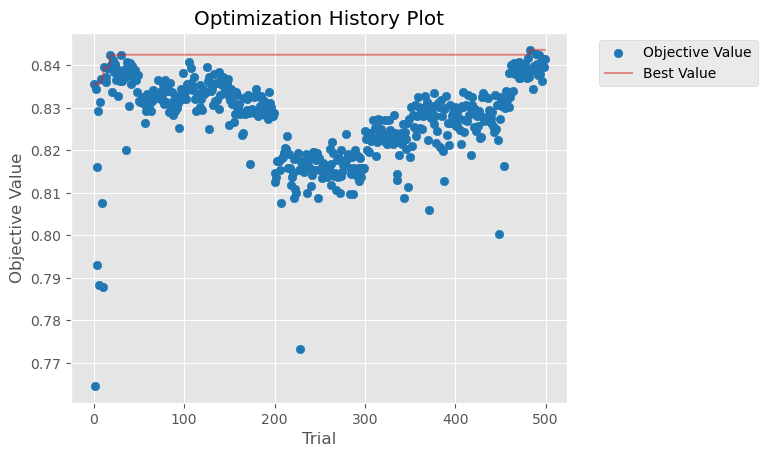

In [95]:
plot_optimization_history(study_xgb);

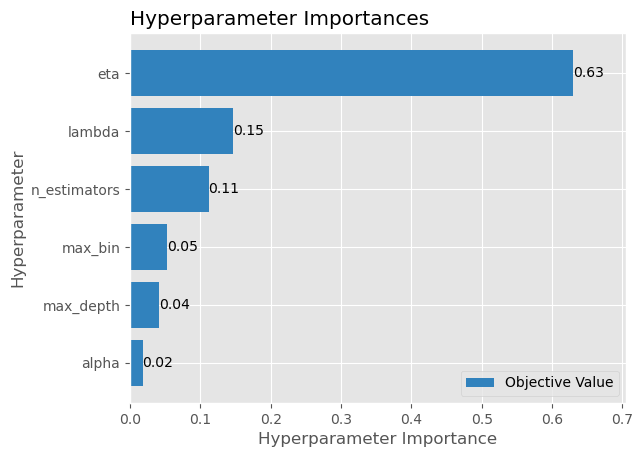

In [96]:
plot_param_importances(study_xgb);

In [97]:
detailed_objective_xgb_CV(study_xgb.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,TP,165.400000,6.883152
1,TN,88.100000,2.806738
2,FP,25.300000,5.034327
3,FN,18.300000,3.591657
4,Accuracy,0.853249,0.025246
5,Precision,0.867195,0.027134
6,Sensitivity,0.900156,0.020528
7,Specificity,0.777910,0.036964
8,F1 score,0.883250,0.021851
9,F1 score (weighted),0.852272,0.025521


In [98]:
mat_met_xgb_test['ave'] = mat_met_xgb_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_xgb_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave
0,TP,326.000000,318.000000,325.000000,328.000000,333.000000,324.000000,336.000000,324.000000,326.000000,329.000000,326.900000
1,TN,169.000000,186.000000,175.000000,176.000000,180.000000,183.000000,173.000000,179.000000,181.000000,165.000000,176.700000
2,FP,58.000000,51.000000,54.000000,62.000000,58.000000,51.000000,40.000000,49.000000,48.000000,62.000000,53.300000
3,FN,42.000000,40.000000,41.000000,29.000000,24.000000,37.000000,46.000000,43.000000,40.000000,39.000000,38.100000
4,Accuracy,0.831933,0.847059,0.840336,0.847059,0.862185,0.852101,0.855462,0.845378,0.852101,0.830252,0.846387
5,Precision,0.848958,0.861789,0.857520,0.841026,0.851662,0.864000,0.893617,0.868633,0.871658,0.841432,0.860029
6,Sensitivity,0.885870,0.888268,0.887978,0.918768,0.932773,0.897507,0.879581,0.882834,0.890710,0.894022,0.895831
7,Specificity,0.744500,0.784800,0.764200,0.739500,0.756300,0.782100,0.812200,0.785100,0.790400,0.726900,0.768600
8,F1 score,0.867021,0.874828,0.872483,0.878179,0.890374,0.880435,0.886544,0.875676,0.881081,0.866930,0.877355
9,F1 score (weighted),0.830651,0.846399,0.839397,0.844741,0.860016,0.851227,0.855894,0.844974,0.851586,0.828295,0.845318


In [99]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)


Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_xgb=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_xgb = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )


        #learn
        eval_set = [(X_test, y_test)]
        optimizedCV_xgb.fit(X_train,y_train, 
            eval_set=eval_set,
            eval_metric=["logloss"],
            early_stopping_rounds=50,
            verbose= False,
                  )
                          
                  
        #print(test_idx)
        y_pred_optimized_xgb = optimizedCV_xgb.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_xgb': y_pred_optimized_xgb } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        
        conf_matrix = confusion_matrix(y_test, y_pred_optimized_xgb)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        Accuracy_outer.append(accuracy_score(y_test, y_pred_optimized_xgb))
        Precision_outer.append(precision_score(y_test, y_pred_optimized_xgb))
        Sensitivity_outer.append(recall_score(y_test, y_pred_optimized_xgb))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test, y_pred_optimized_xgb))
        f1_scores_W_outer.append(f1_score(y_test, y_pred_optimized_xgb, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test, y_pred_optimized_xgb, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test, y_pred_optimized_xgb))
        MCC_outer.append(matthews_corrcoef(y_test, y_pred_optimized_xgb))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test, y_pred_optimized_xgb))
        
    data_xgb['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_xgb['y_test' + str(i)] = data_inner['y_test']
    data_xgb['y_pred_xgb' + str(i)] = data_inner['y_pred_xgb']
   # data_xgb['correct' + str(i)] = correct_value
   # data_xgb['pred' + str(i)] = y_pred_optimized_xgb

mat_met_optimized_xgb = pd.DataFrame({'Metric':['Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 

mat_met_optimized_xgb


,Metric,Value (average),Value (std)
0,Accuracy,0.852773,0.016934
1,Precision,0.865944,0.021339
2,Sensitivity,0.902057,0.018833
3,Specificity,0.772810,0.040438
4,F1 score,0.883375,0.013261
5,F1 score (weighted),0.851603,0.017357
6,F1 score (macro),0.841510,0.019134
7,Balanced Accuracy,0.837432,0.020408
8,MCC,0.685224,0.037852
9,NPV,0.829908,0.029534


In [100]:
#cross valide using this optimized XGBoost 
fit_params = {'early_stopping_rounds': 50, 
            'eval_set': [(X_tr, Y_tr), (X_te, Y_te)],
              'verbose' : False,
             }

xgb_baseline_CVscore = cross_val_score(xgb_clf, X, Y, cv=10, scoring="f1_macro", )
#cv_xgb_opt_testSet = cross_val_score(optimized_xgb, X, Y, cv=10, scoring="f1_macro", fit_params = fit_params)
cv_xgb_opt = cross_val_score(optimizedCV_xgb, X, Y, cv=10, scoring="f1_macro", fit_params = fit_params)
print("XGBoost baseline model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(xgb_baseline_CVscore), np.std(xgb_baseline_CVscore, ddof=1)))
#print("XGBoost optimized model (tested with Y_te) f1_score %0.4f with a standard deviation of %0.4f" % (cv_xgb_opt_testSet.mean(), cv_xgb_opt_testSet.std()))
print("XGBoost optimized model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_xgb_opt), np.std(cv_xgb_opt, ddof=1)))

[17:36:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:36:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:36:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:36:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [101]:
# save the modesls, both the one with optimized hyperparameters and the initial one
joblib.dump(xgb_clf, "OUTPUT/xgb_clf.joblib")

joblib.dump(optimizedCV_xgb, "OUTPUT/optimizedCV_xgb_clf.joblib")


['OUTPUT/optimizedCV_xgb_clf.joblib']

## KNeighbors (KNN)

In [102]:
%%time


TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    knn_clf = KNeighborsClassifier()
    
    knn_clf.fit(X_train,y_train)

    y_pred = knn_clf.predict(X_test) 
    
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test, y_pred)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test, y_pred)
    Precision[idx] = precision_score(y_test, y_pred)
    Sensitivity[idx] = recall_score(y_test, y_pred)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test, y_pred)
    f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
    f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
    MCC[idx] = matthews_corrcoef(y_test, y_pred)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    TP       164.700000     7.689098
1                    TN        81.000000     4.988877
2                    FP        32.400000     5.581716
3                    FN        19.000000     3.711843
4              Accuracy         0.827006     0.027216
5             Precision         0.835611     0.028376
6           Sensitivity         0.896195     0.022185
7           Specificity         0.714830     0.044454
8              F1 score         0.864720     0.023340
9   F1 score (weighted)         0.824530     0.027710
10     F1 score (macro)         0.812022     0.027953
11    Balanced Accuracy         0.805510     0.028298
12                  MCC         0.628369     0.054821
13                  NPV         0.810690     0.029191
14              ROC_AUC         0.805510     0.028298
CPU times: user 3.15 s, sys: 6.81 s, total: 9.96 s
Wall time: 321 ms


In [103]:
def objective_knn_CV(trial, X, Y, Y_class):
    param_grid = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 5, 30),
        "weights" :trial.suggest_categorical("weights", ['uniform', 'distance']),
        "metric" : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        "leaf_size": trial.suggest_int("leaf_size", 20, 100)
        #"device_type": trial.suggestegorical("device_type", ['gpu']),
        
    }
    
   
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        knn_model = KNeighborsClassifier(**param_grid, n_jobs=16)
        knn_model.fit(X_train,y_train)
    
        y_pred = knn_model.predict(X_test)
    
    
        cv_scores[idx] = f1_score(y_test, y_pred, average='macro')
       
        
    return np.mean(cv_scores)

In [104]:
def detailed_objective_knn_CV(trial, X, Y, Y_class):
    param_grid = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 1, 30),
        "weights" :trial.suggest_categorical("weights", ['uniform', 'distance']),
        "metric" : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        "leaf_size": trial.suggest_int("leaf_size", 20, 100)
        #"device_type": trial.suggestegorical("device_type", ['gpu']),      
    }
    
  
    TP =np.empty(10)
    TN = np.empty(10)
    FP = np.empty(10)
    FN = np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M = np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        knn_model = KNeighborsClassifier(**param_grid, n_jobs=16)
        knn_model.fit(X_train,y_train)
    
        y_pred = knn_model.predict(X_test)
        
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test, y_pred)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
    return(mat_met)
    

In [105]:
#Execute optuna and set hyperparameters
study_knn = optuna.create_study(direction='maximize', study_name="KNNClassifier")
func_knn_0 = lambda trial: objective_knn_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_knn.optimize(func_knn_0, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 17:36:46,907] A new study created in memory with name: KNNClassifier
[I 2023-12-04 17:36:47,160] Trial 0 finished with value: 0.8074526085582342 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 55}. Best is trial 0 with value: 0.8074526085582342.
[I 2023-12-04 17:36:47,386] Trial 1 finished with value: 0.8020451121620823 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 61}. Best is trial 0 with value: 0.8074526085582342.
[I 2023-12-04 17:36:47,881] Trial 2 finished with value: 0.7938822489511856 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 22}. Best is trial 0 with value: 0.8074526085582342.
[I 2023-12-04 17:36:48,104] Trial 3 finished with value: 0.8111529914152275 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 65}. Best is trial 3 with value: 0.8111529914152275.
[I 2023-12-04 17:36:48,

	Number of trials: 50.0
	Best value (f1_score): 0.8247
	Best params:
		n_neighbors: 9
		weights: distance
		metric: manhattan
		leaf_size: 63


In [106]:
#Create an instance with tuned hyperparameters

optimized_knn_0 = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_0.fit(X_trainSet0,Y_trainSet0, )

# predict
y_pred_knn_0 = optimized_knn_0.predict(X_testSet0)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0, y_pred_knn_0)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0, y_pred_knn_0)
Precision = precision_score(Y_testSet0, y_pred_knn_0)
Sensitivity = recall_score(Y_testSet0, y_pred_knn_0)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0, y_pred_knn_0)      
f1_scores_W = f1_score(Y_testSet0, y_pred_knn_0, average="weighted")
f1_scores_M = f1_score(Y_testSet0, y_pred_knn_0, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0, y_pred_knn_0)
MCC = matthews_corrcoef(Y_testSet0, y_pred_knn_0)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0, y_pred_knn_0)
    

mat_met_knn_test = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_knn_test)


                 Metric        Set0
0                    TP  323.000000
1                    TN  158.000000
2                    FP   69.000000
3                    FN   45.000000
4              Accuracy    0.808403
5             Precision    0.823980
6           Sensitivity    0.877717
7           Specificity    0.696000
8              F1 score    0.850000
9   F1 score (weighted)    0.806082
10     F1 score (macro)    0.792442
11    Balanced Accuracy    0.786876
12                  MCC    0.587855
13                  NPV    0.778300
14              ROC_AUC    0.786876


In [107]:
#Execute optuna and set hyperparameters

func_knn_1 = lambda trial: objective_knn_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_knn.optimize(func_knn_1, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 17:37:07,252] Trial 50 finished with value: 0.8181343826385923 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 97}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:37:07,731] Trial 51 finished with value: 0.8219105259699331 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 88}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:37:08,239] Trial 52 finished with value: 0.8170770084979084 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 87}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:37:08,743] Trial 53 finished with value: 0.8177501450032008 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 93}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:37:09,210] Trial 54 finished with value: 0.8184074194310451 and parameters: {'n_neighbo

	Number of trials: 100.0
	Best value (f1_score): 0.8247
	Best params:
		n_neighbors: 9
		weights: distance
		metric: manhattan
		leaf_size: 63


In [108]:
#Create an instance with tuned hyperparameters

optimized_knn_1 =  KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_1.fit(X_trainSet1,Y_trainSet1, )

# predict
y_pred_knn_1 = optimized_knn_1.predict(X_testSet1)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1, y_pred_knn_1)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1, y_pred_knn_1)
Precision = precision_score(Y_testSet1, y_pred_knn_1)
Sensitivity = recall_score(Y_testSet1, y_pred_knn_1)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1, y_pred_knn_1)      
f1_scores_W = f1_score(Y_testSet1, y_pred_knn_1, average="weighted")
f1_scores_M = f1_score(Y_testSet1, y_pred_knn_1, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1, y_pred_knn_1)
MCC = matthews_corrcoef(Y_testSet1, y_pred_knn_1)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1, y_pred_knn_1)
    

set1 = pd.DataFrame({'Set1':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set1'] = set1
print(mat_met_knn_test)


                 Metric        Set0        Set1
0                    TP  323.000000  310.000000
1                    TN  158.000000  175.000000
2                    FP   69.000000   62.000000
3                    FN   45.000000   48.000000
4              Accuracy    0.808403    0.815126
5             Precision    0.823980    0.833333
6           Sensitivity    0.877717    0.865922
7           Specificity    0.696000    0.738400
8              F1 score    0.850000    0.849315
9   F1 score (weighted)    0.806082    0.814086
10     F1 score (macro)    0.792442    0.805092
11    Balanced Accuracy    0.786876    0.802159
12                  MCC    0.587855    0.611164
13                  NPV    0.778300    0.784800
14              ROC_AUC    0.786876    0.802159


In [109]:
#Execute optuna and set hyperparameters

func_knn_2 = lambda trial: objective_knn_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_knn.optimize(func_knn_2, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 17:37:28,455] Trial 100 finished with value: 0.8140281449610083 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 67}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:37:28,930] Trial 101 finished with value: 0.8124414606136501 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 94}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:37:29,432] Trial 102 finished with value: 0.8124414606136501 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 92}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:37:29,947] Trial 103 finished with value: 0.8125690993496825 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 96}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:37:30,428] Trial 104 finished with value: 0.8180675934282856 and parameters: {'n_ne

	Number of trials: 150.0
	Best value (f1_score): 0.8247
	Best params:
		n_neighbors: 9
		weights: distance
		metric: manhattan
		leaf_size: 63


In [110]:
#Create an instance with tuned hyperparameters

optimized_knn_2 = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_2.fit(X_trainSet2,Y_trainSet2, )
#predict
y_pred_knn_2 = optimized_knn_2.predict(X_testSet2)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2, y_pred_knn_2)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2, y_pred_knn_2)
Precision = precision_score(Y_testSet2, y_pred_knn_2)
Sensitivity = recall_score(Y_testSet2, y_pred_knn_2)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2, y_pred_knn_2)      
f1_scores_W = f1_score(Y_testSet2, y_pred_knn_2, average="weighted")
f1_scores_M = f1_score(Y_testSet2, y_pred_knn_2, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2, y_pred_knn_2)
MCC = matthews_corrcoef(Y_testSet2, y_pred_knn_2)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2, y_pred_knn_2)
    

Set2 = pd.DataFrame({'Set2':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set2'] = Set2
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2
0                    TP  323.000000  310.000000  326.000000
1                    TN  158.000000  175.000000  162.000000
2                    FP   69.000000   62.000000   67.000000
3                    FN   45.000000   48.000000   40.000000
4              Accuracy    0.808403    0.815126    0.820168
5             Precision    0.823980    0.833333    0.829517
6           Sensitivity    0.877717    0.865922    0.890710
7           Specificity    0.696000    0.738400    0.707400
8              F1 score    0.850000    0.849315    0.859025
9   F1 score (weighted)    0.806082    0.814086    0.817734
10     F1 score (macro)    0.792442    0.805092    0.805383
11    Balanced Accuracy    0.786876    0.802159    0.799067
12                  MCC    0.587855    0.611164    0.614589
13                  NPV    0.778300    0.784800    0.802000
14              ROC_AUC    0.786876    0.802159    0.799067


In [111]:
#Execute optuna and set hyperparameters

func_knn_3 = lambda trial: objective_knn_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_knn.optimize(func_knn_3, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 17:37:49,729] Trial 150 finished with value: 0.8051671005428119 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 91}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:37:50,179] Trial 151 finished with value: 0.8147365034742162 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 40}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:37:50,596] Trial 152 finished with value: 0.806121997778978 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 51}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:37:51,033] Trial 153 finished with value: 0.8054845984650513 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 49}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:37:51,455] Trial 154 finished with value: 0.8069680807910936 and parameters: {'n_neig

	Number of trials: 200.0
	Best value (f1_score): 0.8247
	Best params:
		n_neighbors: 9
		weights: distance
		metric: manhattan
		leaf_size: 63


In [112]:
#Create an instance with tuned hyperparameters

optimized_knn_3 = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_3.fit(X_trainSet3,Y_trainSet3, )

# predict
y_pred_knn_3 = optimized_knn_3.predict(X_testSet3)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3, y_pred_knn_3)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3, y_pred_knn_3)
Precision = precision_score(Y_testSet3, y_pred_knn_3)
Sensitivity = recall_score(Y_testSet3, y_pred_knn_3)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3, y_pred_knn_3)      
f1_scores_W = f1_score(Y_testSet3, y_pred_knn_3, average="weighted")
f1_scores_M = f1_score(Y_testSet3, y_pred_knn_3, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3, y_pred_knn_3)
MCC = matthews_corrcoef(Y_testSet3, y_pred_knn_3)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3, y_pred_knn_3)
    

Set3 = pd.DataFrame({'Set3':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set3'] = Set3
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3
0                    TP  323.000000  310.000000  326.000000  323.000000
1                    TN  158.000000  175.000000  162.000000  173.000000
2                    FP   69.000000   62.000000   67.000000   65.000000
3                    FN   45.000000   48.000000   40.000000   34.000000
4              Accuracy    0.808403    0.815126    0.820168    0.833613
5             Precision    0.823980    0.833333    0.829517    0.832474
6           Sensitivity    0.877717    0.865922    0.890710    0.904762
7           Specificity    0.696000    0.738400    0.707400    0.726900
8              F1 score    0.850000    0.849315    0.859025    0.867114
9   F1 score (weighted)    0.806082    0.814086    0.817734    0.831280
10     F1 score (macro)    0.792442    0.805092    0.805383    0.822321
11    Balanced Accuracy    0.786876    0.802159    0.799067    0.815826
12                  MCC    0.587855    0.611164    0.614589    0

In [113]:
#Execute optuna and set hyperparameters

func_knn_4 = lambda trial: objective_knn_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_knn.optimize(func_knn_4, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 17:38:10,005] Trial 200 finished with value: 0.8072180832778407 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 88}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:38:10,440] Trial 201 finished with value: 0.8096096372488428 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 86}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:38:10,873] Trial 202 finished with value: 0.8080794798840479 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 90}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:38:11,280] Trial 203 finished with value: 0.8078766381544943 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 87}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:38:11,728] Trial 204 finished with value: 0.8096096372488428 and parameters: {'n_ne

	Number of trials: 250.0
	Best value (f1_score): 0.8247
	Best params:
		n_neighbors: 9
		weights: distance
		metric: manhattan
		leaf_size: 63


In [114]:
#Create an instance with tuned hyperparameters

optimized_knn_4 =  KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_4.fit(X_trainSet4,Y_trainSet4, )

# predict
y_pred_knn_4 = optimized_knn_4.predict(X_testSet4)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4, y_pred_knn_4)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4, y_pred_knn_4)
Precision = precision_score(Y_testSet4, y_pred_knn_4)
Sensitivity = recall_score(Y_testSet4, y_pred_knn_4)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4, y_pred_knn_4)      
f1_scores_W = f1_score(Y_testSet4, y_pred_knn_4, average="weighted")
f1_scores_M = f1_score(Y_testSet4, y_pred_knn_4, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4, y_pred_knn_4)
MCC = matthews_corrcoef(Y_testSet4, y_pred_knn_4)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4, y_pred_knn_4)
    

Set4 = pd.DataFrame({'Set4':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set4'] = Set4
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  323.000000  310.000000  326.000000  323.000000   
1                    TN  158.000000  175.000000  162.000000  173.000000   
2                    FP   69.000000   62.000000   67.000000   65.000000   
3                    FN   45.000000   48.000000   40.000000   34.000000   
4              Accuracy    0.808403    0.815126    0.820168    0.833613   
5             Precision    0.823980    0.833333    0.829517    0.832474   
6           Sensitivity    0.877717    0.865922    0.890710    0.904762   
7           Specificity    0.696000    0.738400    0.707400    0.726900   
8              F1 score    0.850000    0.849315    0.859025    0.867114   
9   F1 score (weighted)    0.806082    0.814086    0.817734    0.831280   
10     F1 score (macro)    0.792442    0.805092    0.805383    0.822321   
11    Balanced Accuracy    0.786876    0.802159    0.799067    0.815826   
12                  MCC  

In [115]:
#Execute optuna and set hyperparameters

func_knn_5 = lambda trial: objective_knn_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_knn.optimize(func_knn_5, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 17:38:30,634] Trial 250 finished with value: 0.7968722199969355 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 100}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:38:30,991] Trial 251 finished with value: 0.8034728180652172 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 85}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:38:31,383] Trial 252 finished with value: 0.7988714312042663 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 97}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:38:31,816] Trial 253 finished with value: 0.8034728180652172 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 63}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:38:32,282] Trial 254 finished with value: 0.8011629205763194 and parameters: {'n_n

	Number of trials: 300.0
	Best value (f1_score): 0.8247
	Best params:
		n_neighbors: 9
		weights: distance
		metric: manhattan
		leaf_size: 63


In [116]:
#Create an instance with tuned hyperparameters

optimized_knn_5 = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_5.fit(X_trainSet5,Y_trainSet5, )

# predict
y_pred_knn_5 = optimized_knn_5.predict(X_testSet5)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5, y_pred_knn_5)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5, y_pred_knn_5)
Precision = precision_score(Y_testSet5, y_pred_knn_5)
Sensitivity = recall_score(Y_testSet5, y_pred_knn_5)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5, y_pred_knn_5)      
f1_scores_W = f1_score(Y_testSet5, y_pred_knn_5, average="weighted")
f1_scores_M = f1_score(Y_testSet5, y_pred_knn_5, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5, y_pred_knn_5)
MCC = matthews_corrcoef(Y_testSet5, y_pred_knn_5)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5, y_pred_knn_5)
    

Set5 = pd.DataFrame({'Set5':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set5'] = Set5
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  323.000000  310.000000  326.000000  323.000000   
1                    TN  158.000000  175.000000  162.000000  173.000000   
2                    FP   69.000000   62.000000   67.000000   65.000000   
3                    FN   45.000000   48.000000   40.000000   34.000000   
4              Accuracy    0.808403    0.815126    0.820168    0.833613   
5             Precision    0.823980    0.833333    0.829517    0.832474   
6           Sensitivity    0.877717    0.865922    0.890710    0.904762   
7           Specificity    0.696000    0.738400    0.707400    0.726900   
8              F1 score    0.850000    0.849315    0.859025    0.867114   
9   F1 score (weighted)    0.806082    0.814086    0.817734    0.831280   
10     F1 score (macro)    0.792442    0.805092    0.805383    0.822321   
11    Balanced Accuracy    0.786876    0.802159    0.799067    0.815826   
12                  MCC  

In [117]:
#Execute optuna and set hyperparameters

func_knn_6 = lambda trial: objective_knn_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_knn.optimize(func_knn_6, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 17:38:50,838] Trial 300 finished with value: 0.8096954847671908 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 89}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:38:51,222] Trial 301 finished with value: 0.8148727995507308 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 95}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:38:51,696] Trial 302 finished with value: 0.8156825648453369 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 60}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:38:52,145] Trial 303 finished with value: 0.8124071567804549 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 84}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:38:52,559] Trial 304 finished with value: 0.8111317036357664 and parameters: {'n_ne

	Number of trials: 350.0
	Best value (f1_score): 0.8247
	Best params:
		n_neighbors: 9
		weights: distance
		metric: manhattan
		leaf_size: 63


In [118]:
#Create an instance with tuned hyperparameters

optimized_knn_6 =  KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_6.fit(X_trainSet6,Y_trainSet6, )

# predict
y_pred_knn_6 = optimized_knn_6.predict(X_testSet6)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6, y_pred_knn_6)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6, y_pred_knn_6)
Precision = precision_score(Y_testSet6, y_pred_knn_6)
Sensitivity = recall_score(Y_testSet6, y_pred_knn_6)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6, y_pred_knn_6)      
f1_scores_W = f1_score(Y_testSet6, y_pred_knn_6, average="weighted")
f1_scores_M = f1_score(Y_testSet6, y_pred_knn_6, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6, y_pred_knn_6)
MCC = matthews_corrcoef(Y_testSet6, y_pred_knn_6)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6, y_pred_knn_6)
    

Set6 = pd.DataFrame({'Set6':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set6'] = Set6
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  323.000000  310.000000  326.000000  323.000000   
1                    TN  158.000000  175.000000  162.000000  173.000000   
2                    FP   69.000000   62.000000   67.000000   65.000000   
3                    FN   45.000000   48.000000   40.000000   34.000000   
4              Accuracy    0.808403    0.815126    0.820168    0.833613   
5             Precision    0.823980    0.833333    0.829517    0.832474   
6           Sensitivity    0.877717    0.865922    0.890710    0.904762   
7           Specificity    0.696000    0.738400    0.707400    0.726900   
8              F1 score    0.850000    0.849315    0.859025    0.867114   
9   F1 score (weighted)    0.806082    0.814086    0.817734    0.831280   
10     F1 score (macro)    0.792442    0.805092    0.805383    0.822321   
11    Balanced Accuracy    0.786876    0.802159    0.799067    0.815826   
12                  MCC  

In [119]:
#Execute optuna and set hyperparameters

func_knn_7 = lambda trial: objective_knn_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_knn.optimize(func_knn_7, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 17:39:11,652] Trial 350 finished with value: 0.8186158707694267 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 87}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:39:12,099] Trial 351 finished with value: 0.8132764641223688 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 97}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:39:12,554] Trial 352 finished with value: 0.8146728228104338 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 96}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:39:12,966] Trial 353 finished with value: 0.8196979115661206 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 76}. Best is trial 5 with value: 0.824700223949003.
[I 2023-12-04 17:39:13,405] Trial 354 finished with value: 0.8215429886126419 and parameters: {'n_ne

	Number of trials: 400.0
	Best value (f1_score): 0.8293
	Best params:
		n_neighbors: 10
		weights: distance
		metric: manhattan
		leaf_size: 99


In [120]:
#Create an instance with tuned hyperparameters

optimized_knn_7 =  KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_7.fit(X_trainSet7,Y_trainSet7, )

# predict
y_pred_knn_7 = optimized_knn_7.predict(X_testSet7)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7, y_pred_knn_7)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7, y_pred_knn_7)
Precision = precision_score(Y_testSet7, y_pred_knn_7)
Sensitivity = recall_score(Y_testSet7, y_pred_knn_7)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7, y_pred_knn_7)      
f1_scores_W = f1_score(Y_testSet7, y_pred_knn_7, average="weighted")
f1_scores_M = f1_score(Y_testSet7, y_pred_knn_7, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7, y_pred_knn_7)
MCC = matthews_corrcoef(Y_testSet7, y_pred_knn_7)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7, y_pred_knn_7)
    

Set7 = pd.DataFrame({'Set7':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set7'] = Set7
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  323.000000  310.000000  326.000000  323.000000   
1                    TN  158.000000  175.000000  162.000000  173.000000   
2                    FP   69.000000   62.000000   67.000000   65.000000   
3                    FN   45.000000   48.000000   40.000000   34.000000   
4              Accuracy    0.808403    0.815126    0.820168    0.833613   
5             Precision    0.823980    0.833333    0.829517    0.832474   
6           Sensitivity    0.877717    0.865922    0.890710    0.904762   
7           Specificity    0.696000    0.738400    0.707400    0.726900   
8              F1 score    0.850000    0.849315    0.859025    0.867114   
9   F1 score (weighted)    0.806082    0.814086    0.817734    0.831280   
10     F1 score (macro)    0.792442    0.805092    0.805383    0.822321   
11    Balanced Accuracy    0.786876    0.802159    0.799067    0.815826   
12                  MCC  

In [121]:
#Execute optuna and set hyperparameters

func_knn_8 = lambda trial: objective_knn_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_knn.optimize(func_knn_8, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 17:39:32,785] Trial 400 finished with value: 0.8089632375217019 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 100}. Best is trial 376 with value: 0.8292867381176114.
[I 2023-12-04 17:39:33,226] Trial 401 finished with value: 0.8089632375217019 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 100}. Best is trial 376 with value: 0.8292867381176114.
[I 2023-12-04 17:39:33,650] Trial 402 finished with value: 0.8089632375217019 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 100}. Best is trial 376 with value: 0.8292867381176114.
[I 2023-12-04 17:39:34,080] Trial 403 finished with value: 0.8089632375217019 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 98}. Best is trial 376 with value: 0.8292867381176114.
[I 2023-12-04 17:39:34,494] Trial 404 finished with value: 0.8099403608417738 and par

	Number of trials: 450.0
	Best value (f1_score): 0.8293
	Best params:
		n_neighbors: 10
		weights: distance
		metric: manhattan
		leaf_size: 99


In [122]:
#Create an instance with tuned hyperparameters

optimized_knn_8 =  KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_8.fit(X_trainSet8,Y_trainSet8, )

# predict
y_pred_knn_8 = optimized_knn_8.predict(X_testSet8)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8, y_pred_knn_8)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8, y_pred_knn_8)
Precision = precision_score(Y_testSet8, y_pred_knn_8)
Sensitivity = recall_score(Y_testSet8, y_pred_knn_8)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8, y_pred_knn_8)      
f1_scores_W = f1_score(Y_testSet8, y_pred_knn_8, average="weighted")
f1_scores_M = f1_score(Y_testSet8, y_pred_knn_8, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8, y_pred_knn_8)
MCC = matthews_corrcoef(Y_testSet8, y_pred_knn_8)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8, y_pred_knn_8)
    

Set8 = pd.DataFrame({'Set8':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set8'] = Set8
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  323.000000  310.000000  326.000000  323.000000   
1                    TN  158.000000  175.000000  162.000000  173.000000   
2                    FP   69.000000   62.000000   67.000000   65.000000   
3                    FN   45.000000   48.000000   40.000000   34.000000   
4              Accuracy    0.808403    0.815126    0.820168    0.833613   
5             Precision    0.823980    0.833333    0.829517    0.832474   
6           Sensitivity    0.877717    0.865922    0.890710    0.904762   
7           Specificity    0.696000    0.738400    0.707400    0.726900   
8              F1 score    0.850000    0.849315    0.859025    0.867114   
9   F1 score (weighted)    0.806082    0.814086    0.817734    0.831280   
10     F1 score (macro)    0.792442    0.805092    0.805383    0.822321   
11    Balanced Accuracy    0.786876    0.802159    0.799067    0.815826   
12                  MCC  

In [123]:
#Execute optuna and set hyperparameters

func_knn_9 = lambda trial: objective_knn_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_knn.optimize(func_knn_9, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 17:39:52,665] Trial 450 finished with value: 0.8099498573951704 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 100}. Best is trial 376 with value: 0.8292867381176114.
[I 2023-12-04 17:39:53,102] Trial 451 finished with value: 0.8173609661181931 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 96}. Best is trial 376 with value: 0.8292867381176114.
[I 2023-12-04 17:39:53,523] Trial 452 finished with value: 0.8173609661181931 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 98}. Best is trial 376 with value: 0.8292867381176114.
[I 2023-12-04 17:39:53,953] Trial 453 finished with value: 0.8242321543446979 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 100}. Best is trial 376 with value: 0.8292867381176114.
[I 2023-12-04 17:39:54,391] Trial 454 finished with value: 0.8127857811947455 and param

	Number of trials: 500.0
	Best value (f1_score): 0.8293
	Best params:
		n_neighbors: 10
		weights: distance
		metric: manhattan
		leaf_size: 99


In [124]:
#Create an instance with tuned hyperparameters

optimized_knn_9 = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_9.fit(X_trainSet9,Y_trainSet9, )

# predict
y_pred_knn_9 = optimized_knn_9.predict(X_testSet9)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9, y_pred_knn_9)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9, y_pred_knn_9)
Precision = precision_score(Y_testSet9, y_pred_knn_9)
Sensitivity = recall_score(Y_testSet9, y_pred_knn_9)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9, y_pred_knn_9)      
f1_scores_W = f1_score(Y_testSet9, y_pred_knn_9, average="weighted")
f1_scores_M = f1_score(Y_testSet9, y_pred_knn_9, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9, y_pred_knn_9)
MCC = matthews_corrcoef(Y_testSet9, y_pred_knn_9)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9, y_pred_knn_9)
    

Set9 = pd.DataFrame({'Set9':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set9'] = Set9
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  323.000000  310.000000  326.000000  323.000000   
1                    TN  158.000000  175.000000  162.000000  173.000000   
2                    FP   69.000000   62.000000   67.000000   65.000000   
3                    FN   45.000000   48.000000   40.000000   34.000000   
4              Accuracy    0.808403    0.815126    0.820168    0.833613   
5             Precision    0.823980    0.833333    0.829517    0.832474   
6           Sensitivity    0.877717    0.865922    0.890710    0.904762   
7           Specificity    0.696000    0.738400    0.707400    0.726900   
8              F1 score    0.850000    0.849315    0.859025    0.867114   
9   F1 score (weighted)    0.806082    0.814086    0.817734    0.831280   
10     F1 score (macro)    0.792442    0.805092    0.805383    0.822321   
11    Balanced Accuracy    0.786876    0.802159    0.799067    0.815826   
12                  MCC  

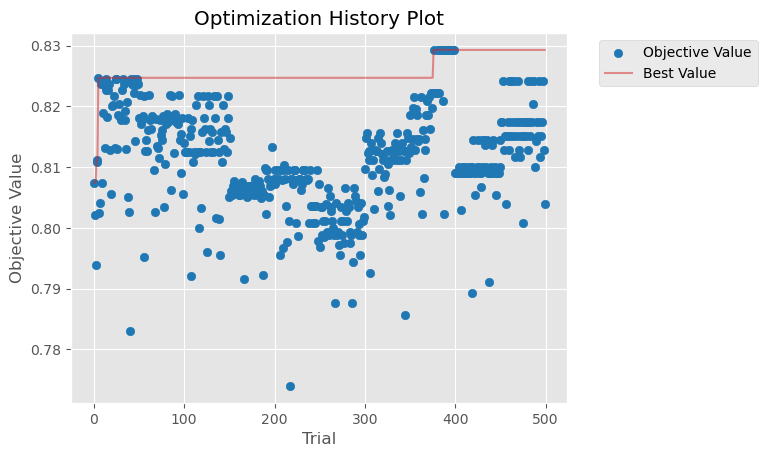

In [125]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_knn);

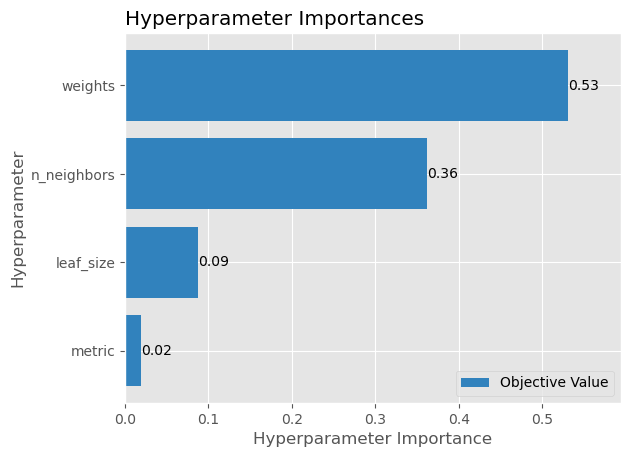

In [126]:

plot_param_importances(study_knn);

In [127]:
detailed_objective_knn_CV(study_knn.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,TP,164.500000,6.553201
1,TN,82.400000,4.351245
2,FP,31.000000,5.270463
3,FN,19.200000,3.155243
4,Accuracy,0.831040,0.023095
5,Precision,0.841504,0.026411
6,Sensitivity,0.895271,0.018282
7,Specificity,0.727280,0.040644
8,F1 score,0.867403,0.019681
9,F1 score (weighted),0.828968,0.023642


In [128]:
mat_met_knn_test['ave'] = mat_met_knn_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_knn_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave
0,TP,323.000000,310.000000,326.000000,323.000000,332.000000,321.000000,330.000000,325.000000,310.000000,319.000000,321.900000
1,TN,158.000000,175.000000,162.000000,173.000000,165.000000,172.000000,164.000000,163.000000,178.000000,159.000000,166.900000
2,FP,69.000000,62.000000,67.000000,65.000000,73.000000,62.000000,49.000000,65.000000,51.000000,68.000000,63.100000
3,FN,45.000000,48.000000,40.000000,34.000000,25.000000,40.000000,52.000000,42.000000,56.000000,49.000000,43.100000
4,Accuracy,0.808403,0.815126,0.820168,0.833613,0.835294,0.828571,0.830252,0.820168,0.820168,0.803361,0.821513
5,Precision,0.823980,0.833333,0.829517,0.832474,0.819753,0.838120,0.870712,0.833333,0.858726,0.824289,0.836424
6,Sensitivity,0.877717,0.865922,0.890710,0.904762,0.929972,0.889197,0.863874,0.885559,0.846995,0.866848,0.882156
7,Specificity,0.696000,0.738400,0.707400,0.726900,0.693300,0.735000,0.770000,0.714900,0.777300,0.700400,0.725960
8,F1 score,0.850000,0.849315,0.859025,0.867114,0.871391,0.862903,0.867280,0.858653,0.852820,0.845033,0.858353
9,F1 score (weighted),0.806082,0.814086,0.817734,0.831280,0.831246,0.826878,0.830511,0.818124,0.820521,0.801541,0.819800


In [129]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)


Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_knn=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_knn = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )


        #learn
        
        optimizedCV_knn.fit(X_train,y_train)
                          
                  
        #print(test_idx)
        y_pred_optimized_knn = optimizedCV_knn.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_knn': y_pred_optimized_knn } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        
        conf_matrix = confusion_matrix(y_test, y_pred_optimized_knn)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        Accuracy_outer.append(accuracy_score(y_test, y_pred_optimized_knn))
        Precision_outer.append(precision_score(y_test, y_pred_optimized_knn))
        Sensitivity_outer.append(recall_score(y_test, y_pred_optimized_knn))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test, y_pred_optimized_knn))
        f1_scores_W_outer.append(f1_score(y_test, y_pred_optimized_knn, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test, y_pred_optimized_knn, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test, y_pred_optimized_knn))
        MCC_outer.append(matthews_corrcoef(y_test, y_pred_optimized_knn))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test, y_pred_optimized_knn))
        
    data_knn['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_knn['y_test' + str(i)] = data_inner['y_test']
    data_knn['y_pred_knn' + str(i)] = data_inner['y_pred_knn']
   # data_knn['correct' + str(i)] = correct_value
   # data_knn['pred' + str(i)] = y_pred_optimized_knn

mat_met_optimized_knn = pd.DataFrame({'Metric':['Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [ np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 

mat_met_optimized_knn


,Metric,Value (average),Value (std)
0,Accuracy,0.830832,0.016548
1,Precision,0.841773,0.023193
2,Sensitivity,0.895303,0.017305
3,Specificity,0.726504,0.044106
4,F1 score,0.867415,0.012829
5,F1 score (weighted),0.828694,0.017377
6,F1 score (macro),0.816475,0.018995
7,Balanced Accuracy,0.810904,0.020665
8,MCC,0.637011,0.036576
9,NPV,0.810974,0.027156


In [130]:
#cross valide using this optimized KNN 
knn_baseline_CVscore = cross_val_score(knn_clf, X, Y, cv=10, scoring="f1_macro")
#cv_knn_opt_testSet = cross_val_score(optimized_knn, X, Y, cv=10, scoring="f1_macro")
cv_knn_opt = cross_val_score(optimizedCV_knn, X, Y, cv=10, scoring="f1_macro")
print("KNN baseline model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(knn_baseline_CVscore), np.std(knn_baseline_CVscore, ddof=1)))
#print("KNN optimized model (tested on Y_te) f1_score %0.4f with a standard deviation of %0.4f" % (cv_knn_opt_testSet.mean(), cv_knn_opt_testSet.std()))
print("KNN optimized model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_knn_opt), np.std(cv_knn_opt, ddof=1)))

KNN baseline model f1_score 0.8136 with a standard deviation of 0.0172
KNN optimized model f1_score 0.8182 with a standard deviation of 0.0203


In [131]:
# save the modesls, both the one with optimized hyperparameters and the initial one
joblib.dump(knn_clf, "OUTPUT/knn_clf.joblib")
joblib.dump(optimizedCV_knn, "OUTPUT/optimizedCV_knn_clf.joblib")


['OUTPUT/optimizedCV_knn_clf.joblib']

## Support Vector 

In [132]:
%%time


TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    svm_clf = SVC()
    
    svm_clf.fit(X_train, y_train, )

    y_pred = svm_clf.predict(X_test) 
   
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test, y_pred)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test, y_pred)
    Precision[idx] = precision_score(y_test, y_pred)
    Sensitivity[idx] = recall_score(y_test, y_pred)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test, y_pred)
    f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
    f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
    MCC[idx] = matthews_corrcoef(y_test, y_pred)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       }) 
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    TP       165.100000     6.573516
1                    TN        85.500000     4.527693
2                    FP        27.900000     5.043147
3                    FN        18.600000     4.325634
4              Accuracy         0.843487     0.022288
5             Precision         0.855581     0.024932
6           Sensitivity         0.898649     0.024036
7           Specificity         0.754520     0.039571
8              F1 score         0.876347     0.019208
9   F1 score (weighted)         0.842020     0.022527
10     F1 score (macro)         0.831307     0.023024
11    Balanced Accuracy         0.826585     0.023399
12                  MCC         0.665372     0.045622
13                  NPV         0.822370     0.034394
14              ROC_AUC         0.826585     0.023399
CPU times: user 7.26 s, sys: 3.99 ms, total: 7.26 s
Wall time: 7.26 s


In [133]:
def objective_svm_CV(trial, X, Y, Y_class):
    param_grid = {
        "C" : trial.suggest_categorical("C", [np.exp2(-7), np.exp2(-6), np.exp2(-5), np.exp2(-4), np.exp2(-3), np.exp2(-2),
                                              np.exp2(-1), np.exp2(0), np.exp2(1), np.exp2(2), np.exp2(3), np.exp2(4),
                                             np.exp2(5), np.exp2(6), np.exp2(7)]),
        "gamma" :trial.suggest_categorical("gamma", [np.exp2(-15), np.exp2(-14), np.exp2(-13), np.exp2(-12), np.exp2(-11), 
                                                     np.exp2(-10),np.exp2(-9), np.exp2(-8), np.exp2(-7), np.exp2(-6), np.exp2(-5), 
                                                     np.exp2(-4),np.exp2(-3), np.exp2(-2), np.exp2(-1), np.exp2(0), np.exp2(1),
                                                     np.exp2(2), np.exp2(3)]),
        #"kernel" : trial.suggestegorical("kernel", ['linear', 'rbf', 'sigmoid']),
        #"degree": trial.suggest_int("degree", 3, 10)
        #"device_type": trial.suggestegorical("device_type", ['gpu'])
        
    }
    
    
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        svm_model = SVC(**param_grid)
        svm_model.fit(X_train,y_train)
    
        y_pred = svm_model.predict(X_test)
    
    
        cv_scores[idx] = f1_score(y_test, y_pred, average='macro')
       
        
    return np.mean(cv_scores)


In [134]:
def detailed_objective_svm_cv(trial, X, Y, Y_class):
    param_grid = {
        "C" : trial.suggest_categorical("C", [np.exp2(-7), np.exp2(-6), np.exp2(-5), np.exp2(-4), np.exp2(-3), np.exp2(-2),
                                              np.exp2(-1), np.exp2(0), np.exp2(1), np.exp2(2), np.exp2(3), np.exp2(4),
                                             np.exp2(5), np.exp2(6), np.exp2(7)]),
        "gamma" :trial.suggest_categorical("gamma", [np.exp2(-15), np.exp2(-14), np.exp2(-13), np.exp2(-12), np.exp2(-11), 
                                                     np.exp2(-10),np.exp2(-9), np.exp2(-8), np.exp2(-7), np.exp2(-6), np.exp2(-5), 
                                                     np.exp2(-4),np.exp2(-3), np.exp2(-2), np.exp2(-1), np.exp2(0), np.exp2(1),
                                                     np.exp2(2), np.exp2(3)]),
        #"kernel" : trial.suggestegorical("kernel", ['linear', 'rbf', 'sigmoid']),
        #"degree": trial.suggest_int("degree", 3, 10)
        #"device_type": trial.suggestegorical("device_type", ['gpu']),
        
    }
    
  
    TP =np.empty(10)
    TN = np.empty(10)
    FP = np.empty(10)
    FN = np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M = np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)

    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        svm_model = SVC(**param_grid)
        svm_model.fit(X_train,y_train)
    
        y_pred = svm_model.predict(X_test)
        
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test, y_pred)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
    return(mat_met)
   

In [135]:
#Execute optuna and set hyperparameters
study_svm = optuna.create_study(direction='maximize', study_name="SVM_classifier")
func_svm_0 = lambda trial: objective_svm_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_svm.optimize(func_svm_0, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 17:40:27,582] A new study created in memory with name: SVM_classifier
[I 2023-12-04 17:40:35,410] Trial 0 finished with value: 0.38192489052100653 and parameters: {'C': 0.125, 'gamma': 8.0}. Best is trial 0 with value: 0.38192489052100653.
[I 2023-12-04 17:40:40,963] Trial 1 finished with value: 0.671028531184511 and parameters: {'C': 0.125, 'gamma': 0.0078125}. Best is trial 1 with value: 0.671028531184511.
[I 2023-12-04 17:40:47,528] Trial 2 finished with value: 0.38192489052100653 and parameters: {'C': 0.0078125, 'gamma': 2.0}. Best is trial 1 with value: 0.671028531184511.
[I 2023-12-04 17:40:51,591] Trial 3 finished with value: 0.8095756119165864 and parameters: {'C': 128.0, 'gamma': 0.00390625}. Best is trial 3 with value: 0.8095756119165864.
[I 2023-12-04 17:40:57,203] Trial 4 finished with value: 0.4813467579549332 and parameters: {'C': 0.0625, 'gamma': 0.0078125}. Best is trial 3 with value: 0.8095756119165864.
[I 2023-12-04 17:41:04,002] Trial 5 finished with va

	Number of trials: 50.0
	Best value (f1_score): 0.8429
	Best params:
		C: 128.0
		gamma: 0.03125


In [136]:
#Create an instance with tuned hyperparameters

optimized_svm_0 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_0.fit(X_trainSet0,Y_trainSet0,)

# predict
y_pred_svm_0 = optimized_svm_0.predict(X_testSet0)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0, y_pred_svm_0)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0, y_pred_svm_0)
Precision = precision_score(Y_testSet0, y_pred_svm_0)
Sensitivity = recall_score(Y_testSet0, y_pred_svm_0)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0, y_pred_svm_0)      
f1_scores_W = f1_score(Y_testSet0, y_pred_svm_0, average="weighted")
f1_scores_M = f1_score(Y_testSet0, y_pred_svm_0, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0, y_pred_svm_0)
MCC = matthews_corrcoef(Y_testSet0, y_pred_svm_0)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0, y_pred_svm_0)
    

mat_met_svm_test = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_svm_test)


                 Metric        Set0
0                    TP  328.000000
1                    TN  164.000000
2                    FP   63.000000
3                    FN   40.000000
4              Accuracy    0.826891
5             Precision    0.838875
6           Sensitivity    0.891304
7           Specificity    0.722500
8              F1 score    0.864295
9   F1 score (weighted)    0.824895
10     F1 score (macro)    0.812658
11    Balanced Accuracy    0.806886
12                  MCC    0.628116
13                  NPV    0.803900
14              ROC_AUC    0.806886


In [137]:
#Execute optuna and set hyperparameters
func_svm_1 = lambda trial: objective_svm_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_svm.optimize(func_svm_1, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 17:45:32,651] Trial 50 finished with value: 0.40309695827455494 and parameters: {'C': 4.0, 'gamma': 4.0}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 17:45:39,317] Trial 51 finished with value: 0.8237801584983535 and parameters: {'C': 4.0, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 17:45:45,981] Trial 52 finished with value: 0.8237801584983535 and parameters: {'C': 4.0, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 17:45:51,985] Trial 53 finished with value: 0.7401922402205867 and parameters: {'C': 0.25, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 17:45:56,562] Trial 54 finished with value: 0.7635947702693132 and parameters: {'C': 2.0, 'gamma': 0.0009765625}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 17:46:03,183] Trial 55 finished with value: 0.42489235479072374 and parameters: {'C': 16.0, 'gamma': 0.5}. Best is trial 9 with 

	Number of trials: 100.0
	Best value (f1_score): 0.8429
	Best params:
		C: 128.0
		gamma: 0.03125


In [138]:
#Create an instance with tuned hyperparameters

optimized_svm_1 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_1.fit(X_trainSet1,Y_trainSet1,)

# predict
y_pred_svm_1 = optimized_svm_1.predict(X_testSet1)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1, y_pred_svm_1)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1, y_pred_svm_1)
Precision = precision_score(Y_testSet1, y_pred_svm_1)
Sensitivity = recall_score(Y_testSet1, y_pred_svm_1)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1, y_pred_svm_1)      
f1_scores_W = f1_score(Y_testSet1, y_pred_svm_1, average="weighted")
f1_scores_M = f1_score(Y_testSet1, y_pred_svm_1, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1, y_pred_svm_1)
MCC = matthews_corrcoef(Y_testSet1, y_pred_svm_1)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1, y_pred_svm_1)
    

set1 = pd.DataFrame({'Set1':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set1'] = set1
print(mat_met_svm_test)


                 Metric        Set0        Set1
0                    TP  328.000000  319.000000
1                    TN  164.000000  181.000000
2                    FP   63.000000   56.000000
3                    FN   40.000000   39.000000
4              Accuracy    0.826891    0.840336
5             Precision    0.838875    0.850667
6           Sensitivity    0.891304    0.891061
7           Specificity    0.722500    0.763700
8              F1 score    0.864295    0.870396
9   F1 score (weighted)    0.824895    0.839218
10     F1 score (macro)    0.812658    0.831259
11    Balanced Accuracy    0.806886    0.827387
12                  MCC    0.628116    0.664019
13                  NPV    0.803900    0.822700
14              ROC_AUC    0.806886    0.827387


In [139]:
#Execute optuna and set hyperparameters
func_svm_2 = lambda trial: objective_svm_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_svm.optimize(func_svm_2, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 17:50:40,959] Trial 100 finished with value: 0.46012554289283125 and parameters: {'C': 128.0, 'gamma': 0.25}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 17:50:47,394] Trial 101 finished with value: 0.8279262854205752 and parameters: {'C': 4.0, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 17:50:53,852] Trial 102 finished with value: 0.8279262854205752 and parameters: {'C': 4.0, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 17:51:00,368] Trial 103 finished with value: 0.8279262854205752 and parameters: {'C': 4.0, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 17:51:08,494] Trial 104 finished with value: 0.4074396451434915 and parameters: {'C': 4.0, 'gamma': 8.0}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 17:51:15,482] Trial 105 finished with value: 0.41193471330424003 and parameters: {'C': 4.0, 'gamma': 2.0}. Best is trial 9 with va

	Number of trials: 150.0
	Best value (f1_score): 0.8429
	Best params:
		C: 128.0
		gamma: 0.03125


In [140]:
#Create an instance with tuned hyperparameters

optimized_svm_2 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_2.fit(X_trainSet2,Y_trainSet2,)

# predict
y_pred_svm_2 = optimized_svm_2.predict(X_testSet2)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2, y_pred_svm_2)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2, y_pred_svm_2)
Precision = precision_score(Y_testSet2, y_pred_svm_2)
Sensitivity = recall_score(Y_testSet2, y_pred_svm_2)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2, y_pred_svm_2)      
f1_scores_W = f1_score(Y_testSet2, y_pred_svm_2, average="weighted")
f1_scores_M = f1_score(Y_testSet2, y_pred_svm_2, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2, y_pred_svm_2)
MCC = matthews_corrcoef(Y_testSet2, y_pred_svm_2)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2, y_pred_svm_2)
    

Set2 = pd.DataFrame({'Set2':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set2'] = Set2
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2
0                    TP  328.000000  319.000000  324.000000
1                    TN  164.000000  181.000000  169.000000
2                    FP   63.000000   56.000000   60.000000
3                    FN   40.000000   39.000000   42.000000
4              Accuracy    0.826891    0.840336    0.828571
5             Precision    0.838875    0.850667    0.843750
6           Sensitivity    0.891304    0.891061    0.885246
7           Specificity    0.722500    0.763700    0.738000
8              F1 score    0.864295    0.870396    0.864000
9   F1 score (weighted)    0.824895    0.839218    0.827122
10     F1 score (macro)    0.812658    0.831259    0.816091
11    Balanced Accuracy    0.806886    0.827387    0.811619
12                  MCC    0.628116    0.664019    0.633877
13                  NPV    0.803900    0.822700    0.800900
14              ROC_AUC    0.806886    0.827387    0.811619


In [141]:
#Execute optuna and set hyperparameters
func_svm_3 = lambda trial: objective_svm_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_svm.optimize(func_svm_3, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 17:55:43,218] Trial 150 finished with value: 0.8279641380281199 and parameters: {'C': 2.0, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 17:55:49,757] Trial 151 finished with value: 0.8279641380281199 and parameters: {'C': 2.0, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 17:55:56,294] Trial 152 finished with value: 0.8279641380281199 and parameters: {'C': 2.0, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 17:56:02,064] Trial 153 finished with value: 0.38371792981115166 and parameters: {'C': 2.0, 'gamma': 6.103515625e-05}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 17:56:08,293] Trial 154 finished with value: 0.38371792981115166 and parameters: {'C': 0.0078125, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 17:56:15,088] Trial 155 finished with value: 0.8226435608932325 and parameters: {'C': 4.0, 'gamma': 0.03125}. 

	Number of trials: 200.0
	Best value (f1_score): 0.8429
	Best params:
		C: 128.0
		gamma: 0.03125


In [142]:
#Create an instance with tuned hyperparameters

optimized_svm_3 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_3.fit(X_trainSet3,Y_trainSet3,)

# predict
y_pred_svm_3 = optimized_svm_3.predict(X_testSet3)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3, y_pred_svm_3)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3, y_pred_svm_3)
Precision = precision_score(Y_testSet3, y_pred_svm_3)
Sensitivity = recall_score(Y_testSet3, y_pred_svm_3)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3, y_pred_svm_3)      
f1_scores_W = f1_score(Y_testSet3, y_pred_svm_3, average="weighted")
f1_scores_M = f1_score(Y_testSet3, y_pred_svm_3, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3, y_pred_svm_3)
MCC = matthews_corrcoef(Y_testSet3, y_pred_svm_3)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3, y_pred_svm_3)
    

Set3 = pd.DataFrame({'Set3':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set3'] = Set3
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3
0                    TP  328.000000  319.000000  324.000000  327.000000
1                    TN  164.000000  181.000000  169.000000  172.000000
2                    FP   63.000000   56.000000   60.000000   66.000000
3                    FN   40.000000   39.000000   42.000000   30.000000
4              Accuracy    0.826891    0.840336    0.828571    0.838655
5             Precision    0.838875    0.850667    0.843750    0.832061
6           Sensitivity    0.891304    0.891061    0.885246    0.915966
7           Specificity    0.722500    0.763700    0.738000    0.722700
8              F1 score    0.864295    0.870396    0.864000    0.872000
9   F1 score (weighted)    0.824895    0.839218    0.827122    0.835927
10     F1 score (macro)    0.812658    0.831259    0.816091    0.826909
11    Balanced Accuracy    0.806886    0.827387    0.811619    0.819328
12                  MCC    0.628116    0.664019    0.633877    0

In [143]:
#Execute optuna and set hyperparameters
func_svm_4 = lambda trial: objective_svm_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_svm.optimize(func_svm_4, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 18:00:26,117] Trial 200 finished with value: 0.8222868980344817 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:00:30,753] Trial 201 finished with value: 0.8206632932622784 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:00:35,398] Trial 202 finished with value: 0.8206632932622784 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:00:40,032] Trial 203 finished with value: 0.8206632932622784 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:00:48,020] Trial 204 finished with value: 0.4119920735244115 and parameters: {'C': 2.0, 'gamma': 8.0}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:00:54,029] Trial 205 finished with value: 0.8212934099319298 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 9

	Number of trials: 250.0
	Best value (f1_score): 0.8429
	Best params:
		C: 128.0
		gamma: 0.03125


In [144]:
#Create an instance with tuned hyperparameters

optimized_svm_4 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_4.fit(X_trainSet4,Y_trainSet4,)

# predict
y_pred_svm_4 = optimized_svm_4.predict(X_testSet4)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4, y_pred_svm_4)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4, y_pred_svm_4)
Precision = precision_score(Y_testSet4, y_pred_svm_4)
Sensitivity = recall_score(Y_testSet4, y_pred_svm_4)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4, y_pred_svm_4)      
f1_scores_W = f1_score(Y_testSet4, y_pred_svm_4, average="weighted")
f1_scores_M = f1_score(Y_testSet4, y_pred_svm_4, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4, y_pred_svm_4)
MCC = matthews_corrcoef(Y_testSet4, y_pred_svm_4)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4, y_pred_svm_4)
    

Set4 = pd.DataFrame({'Set4':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set4'] = Set4
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  328.000000  319.000000  324.000000  327.000000   
1                    TN  164.000000  181.000000  169.000000  172.000000   
2                    FP   63.000000   56.000000   60.000000   66.000000   
3                    FN   40.000000   39.000000   42.000000   30.000000   
4              Accuracy    0.826891    0.840336    0.828571    0.838655   
5             Precision    0.838875    0.850667    0.843750    0.832061   
6           Sensitivity    0.891304    0.891061    0.885246    0.915966   
7           Specificity    0.722500    0.763700    0.738000    0.722700   
8              F1 score    0.864295    0.870396    0.864000    0.872000   
9   F1 score (weighted)    0.824895    0.839218    0.827122    0.835927   
10     F1 score (macro)    0.812658    0.831259    0.816091    0.826909   
11    Balanced Accuracy    0.806886    0.827387    0.811619    0.819328   
12                  MCC  

In [145]:
#Execute optuna and set hyperparameters
func_svm_5 = lambda trial: objective_svm_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_svm.optimize(func_svm_5, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 18:05:02,922] Trial 250 finished with value: 0.8076960168192852 and parameters: {'C': 2.0, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:05:10,061] Trial 251 finished with value: 0.45926588859122763 and parameters: {'C': 4.0, 'gamma': 0.25}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:05:14,977] Trial 252 finished with value: 0.8124509387021364 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:05:21,668] Trial 253 finished with value: 0.8034902779357171 and parameters: {'C': 4.0, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:05:29,984] Trial 254 finished with value: 0.41025580891342434 and parameters: {'C': 1.0, 'gamma': 8.0}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:05:34,896] Trial 255 finished with value: 0.8124509387021364 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 9 wit

	Number of trials: 300.0
	Best value (f1_score): 0.8429
	Best params:
		C: 128.0
		gamma: 0.03125


In [146]:
#Create an instance with tuned hyperparameters

optimized_svm_5 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_5.fit(X_trainSet5,Y_trainSet5,)

# predict
y_pred_svm_5 = optimized_svm_5.predict(X_testSet5)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5, y_pred_svm_5)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5, y_pred_svm_5)
Precision = precision_score(Y_testSet5, y_pred_svm_5)
Sensitivity = recall_score(Y_testSet5, y_pred_svm_5)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5, y_pred_svm_5)      
f1_scores_W = f1_score(Y_testSet5, y_pred_svm_5, average="weighted")
f1_scores_M = f1_score(Y_testSet5, y_pred_svm_5, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5, y_pred_svm_5)
MCC = matthews_corrcoef(Y_testSet5, y_pred_svm_5)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5, y_pred_svm_5)
    

Set5 = pd.DataFrame({'Set5':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set5'] = Set5
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  328.000000  319.000000  324.000000  327.000000   
1                    TN  164.000000  181.000000  169.000000  172.000000   
2                    FP   63.000000   56.000000   60.000000   66.000000   
3                    FN   40.000000   39.000000   42.000000   30.000000   
4              Accuracy    0.826891    0.840336    0.828571    0.838655   
5             Precision    0.838875    0.850667    0.843750    0.832061   
6           Sensitivity    0.891304    0.891061    0.885246    0.915966   
7           Specificity    0.722500    0.763700    0.738000    0.722700   
8              F1 score    0.864295    0.870396    0.864000    0.872000   
9   F1 score (weighted)    0.824895    0.839218    0.827122    0.835927   
10     F1 score (macro)    0.812658    0.831259    0.816091    0.826909   
11    Balanced Accuracy    0.806886    0.827387    0.811619    0.819328   
12                  MCC  

In [147]:
#Execute optuna and set hyperparameters
func_svm_6 = lambda trial: objective_svm_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_svm.optimize(func_svm_6, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 18:09:56,337] Trial 300 finished with value: 0.8100784746364791 and parameters: {'C': 64.0, 'gamma': 0.0625}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:10:02,434] Trial 301 finished with value: 0.8254442748185762 and parameters: {'C': 128.0, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:10:08,860] Trial 302 finished with value: 0.4148927703218172 and parameters: {'C': 2.0, 'gamma': 2.0}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:10:12,847] Trial 303 finished with value: 0.8077392602893099 and parameters: {'C': 4.0, 'gamma': 0.001953125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:10:18,697] Trial 304 finished with value: 0.8201215544999279 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:10:24,782] Trial 305 finished with value: 0.822654582725594 and parameters: {'C': 2.0, 'gamma': 0.03125}. Best is trial

	Number of trials: 350.0
	Best value (f1_score): 0.8429
	Best params:
		C: 128.0
		gamma: 0.03125


In [148]:
#Create an instance with tuned hyperparameters

optimized_svm_6 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_6.fit(X_trainSet6,Y_trainSet6,)

# predict
y_pred_svm_6 = optimized_svm_6.predict(X_testSet6)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6, y_pred_svm_6)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6, y_pred_svm_6)
Precision = precision_score(Y_testSet6, y_pred_svm_6)
Sensitivity = recall_score(Y_testSet6, y_pred_svm_6)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6, y_pred_svm_6)      
f1_scores_W = f1_score(Y_testSet6, y_pred_svm_6, average="weighted")
f1_scores_M = f1_score(Y_testSet6, y_pred_svm_6, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6, y_pred_svm_6)
MCC = matthews_corrcoef(Y_testSet6, y_pred_svm_6)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6, y_pred_svm_6)
    

Set6 = pd.DataFrame({'Set6':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set6'] = Set6
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  328.000000  319.000000  324.000000  327.000000   
1                    TN  164.000000  181.000000  169.000000  172.000000   
2                    FP   63.000000   56.000000   60.000000   66.000000   
3                    FN   40.000000   39.000000   42.000000   30.000000   
4              Accuracy    0.826891    0.840336    0.828571    0.838655   
5             Precision    0.838875    0.850667    0.843750    0.832061   
6           Sensitivity    0.891304    0.891061    0.885246    0.915966   
7           Specificity    0.722500    0.763700    0.738000    0.722700   
8              F1 score    0.864295    0.870396    0.864000    0.872000   
9   F1 score (weighted)    0.824895    0.839218    0.827122    0.835927   
10     F1 score (macro)    0.812658    0.831259    0.816091    0.826909   
11    Balanced Accuracy    0.806886    0.827387    0.811619    0.819328   
12                  MCC  

In [149]:
#Execute optuna and set hyperparameters
func_svm_7 = lambda trial: objective_svm_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_svm.optimize(func_svm_7, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 18:14:45,888] Trial 350 finished with value: 0.8334296579409186 and parameters: {'C': 2.0, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:14:52,089] Trial 351 finished with value: 0.38213913629750335 and parameters: {'C': 0.03125, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:14:58,214] Trial 352 finished with value: 0.5476536463146766 and parameters: {'C': 0.125, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:15:04,765] Trial 353 finished with value: 0.8279480780144043 and parameters: {'C': 4.0, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:15:11,209] Trial 354 finished with value: 0.8334296579409186 and parameters: {'C': 2.0, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:15:17,015] Trial 355 finished with value: 0.8023319824304247 and parameters: {'C': 0.5, 'gamma': 0.03125}. Best is t

	Number of trials: 400.0
	Best value (f1_score): 0.8429
	Best params:
		C: 128.0
		gamma: 0.03125


In [150]:
#Create an instance with tuned hyperparameters

optimized_svm_7 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_7.fit(X_trainSet7,Y_trainSet7,)

# predict
y_pred_svm_7 = optimized_svm_7.predict(X_testSet7)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7, y_pred_svm_7)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7, y_pred_svm_7)
Precision = precision_score(Y_testSet7, y_pred_svm_7)
Sensitivity = recall_score(Y_testSet7, y_pred_svm_7)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7, y_pred_svm_7)      
f1_scores_W = f1_score(Y_testSet7, y_pred_svm_7, average="weighted")
f1_scores_M = f1_score(Y_testSet7, y_pred_svm_7, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7, y_pred_svm_7)
MCC = matthews_corrcoef(Y_testSet7, y_pred_svm_7)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7, y_pred_svm_7)
    

Set7 = pd.DataFrame({'Set7':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set7'] = Set7
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  328.000000  319.000000  324.000000  327.000000   
1                    TN  164.000000  181.000000  169.000000  172.000000   
2                    FP   63.000000   56.000000   60.000000   66.000000   
3                    FN   40.000000   39.000000   42.000000   30.000000   
4              Accuracy    0.826891    0.840336    0.828571    0.838655   
5             Precision    0.838875    0.850667    0.843750    0.832061   
6           Sensitivity    0.891304    0.891061    0.885246    0.915966   
7           Specificity    0.722500    0.763700    0.738000    0.722700   
8              F1 score    0.864295    0.870396    0.864000    0.872000   
9   F1 score (weighted)    0.824895    0.839218    0.827122    0.835927   
10     F1 score (macro)    0.812658    0.831259    0.816091    0.826909   
11    Balanced Accuracy    0.806886    0.827387    0.811619    0.819328   
12                  MCC  

In [151]:
#Execute optuna and set hyperparameters
func_svm_8 = lambda trial: objective_svm_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_svm.optimize(func_svm_8, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 18:20:03,597] Trial 400 finished with value: 0.8277673173209882 and parameters: {'C': 4.0, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:20:09,628] Trial 401 finished with value: 0.8236043688338587 and parameters: {'C': 1.0, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:20:15,915] Trial 402 finished with value: 0.8269732017671373 and parameters: {'C': 2.0, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:20:22,393] Trial 403 finished with value: 0.8248690508109924 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:20:28,971] Trial 404 finished with value: 0.8277673173209882 and parameters: {'C': 4.0, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:20:35,368] Trial 405 finished with value: 0.8269732017671373 and parameters: {'C': 2.0, 'gamma': 0.03125}. Best is trial 9 

	Number of trials: 450.0
	Best value (f1_score): 0.8429
	Best params:
		C: 128.0
		gamma: 0.03125


In [152]:
#Create an instance with tuned hyperparameters

optimized_svm_8 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_8.fit(X_trainSet8,Y_trainSet8,)

# predict
y_pred_svm_8 = optimized_svm_8.predict(X_testSet8)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8, y_pred_svm_8)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8, y_pred_svm_8)
Precision = precision_score(Y_testSet8, y_pred_svm_8)
Sensitivity = recall_score(Y_testSet8, y_pred_svm_8)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8, y_pred_svm_8)      
f1_scores_W = f1_score(Y_testSet8, y_pred_svm_8, average="weighted")
f1_scores_M = f1_score(Y_testSet8, y_pred_svm_8, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8, y_pred_svm_8)
MCC = matthews_corrcoef(Y_testSet8, y_pred_svm_8)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8, y_pred_svm_8)
    

Set8 = pd.DataFrame({'Set8':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set8'] = Set8
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  328.000000  319.000000  324.000000  327.000000   
1                    TN  164.000000  181.000000  169.000000  172.000000   
2                    FP   63.000000   56.000000   60.000000   66.000000   
3                    FN   40.000000   39.000000   42.000000   30.000000   
4              Accuracy    0.826891    0.840336    0.828571    0.838655   
5             Precision    0.838875    0.850667    0.843750    0.832061   
6           Sensitivity    0.891304    0.891061    0.885246    0.915966   
7           Specificity    0.722500    0.763700    0.738000    0.722700   
8              F1 score    0.864295    0.870396    0.864000    0.872000   
9   F1 score (weighted)    0.824895    0.839218    0.827122    0.835927   
10     F1 score (macro)    0.812658    0.831259    0.816091    0.826909   
11    Balanced Accuracy    0.806886    0.827387    0.811619    0.819328   
12                  MCC  

In [153]:
#Execute optuna and set hyperparameters
func_svm_9 = lambda trial: objective_svm_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_svm.optimize(func_svm_9, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 18:25:20,298] Trial 450 finished with value: 0.8328215591430148 and parameters: {'C': 2.0, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:25:26,894] Trial 451 finished with value: 0.8315465135013905 and parameters: {'C': 4.0, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:25:34,018] Trial 452 finished with value: 0.4309968325799904 and parameters: {'C': 2.0, 'gamma': 0.5}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:25:40,598] Trial 453 finished with value: 0.8315465135013905 and parameters: {'C': 4.0, 'gamma': 0.03125}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:25:46,452] Trial 454 finished with value: 0.3819875388704367 and parameters: {'C': 2.0, 'gamma': 3.0517578125e-05}. Best is trial 9 with value: 0.8428953030073378.
[I 2023-12-04 18:25:52,324] Trial 455 finished with value: 0.3819875388704367 and parameters: {'C': 0.0078125, 'gamma': 0.0009765625}. 

	Number of trials: 500.0
	Best value (f1_score): 0.8429
	Best params:
		C: 128.0
		gamma: 0.03125


In [154]:
#Create an instance with tuned hyperparameters

optimized_svm_9 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_9.fit(X_trainSet9,Y_trainSet9,)

# predict
y_pred_svm_9 = optimized_svm_9.predict(X_testSet9)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9, y_pred_svm_9)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9, y_pred_svm_9)
Precision = precision_score(Y_testSet9, y_pred_svm_9)
Sensitivity = recall_score(Y_testSet9, y_pred_svm_9)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9, y_pred_svm_9)      
f1_scores_W = f1_score(Y_testSet9, y_pred_svm_9, average="weighted")
f1_scores_M = f1_score(Y_testSet9, y_pred_svm_9, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9, y_pred_svm_9)
MCC = matthews_corrcoef(Y_testSet9, y_pred_svm_9)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9, y_pred_svm_9)
    

Set9 = pd.DataFrame({'Set9':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set9'] = Set9
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  328.000000  319.000000  324.000000  327.000000   
1                    TN  164.000000  181.000000  169.000000  172.000000   
2                    FP   63.000000   56.000000   60.000000   66.000000   
3                    FN   40.000000   39.000000   42.000000   30.000000   
4              Accuracy    0.826891    0.840336    0.828571    0.838655   
5             Precision    0.838875    0.850667    0.843750    0.832061   
6           Sensitivity    0.891304    0.891061    0.885246    0.915966   
7           Specificity    0.722500    0.763700    0.738000    0.722700   
8              F1 score    0.864295    0.870396    0.864000    0.872000   
9   F1 score (weighted)    0.824895    0.839218    0.827122    0.835927   
10     F1 score (macro)    0.812658    0.831259    0.816091    0.826909   
11    Balanced Accuracy    0.806886    0.827387    0.811619    0.819328   
12                  MCC  

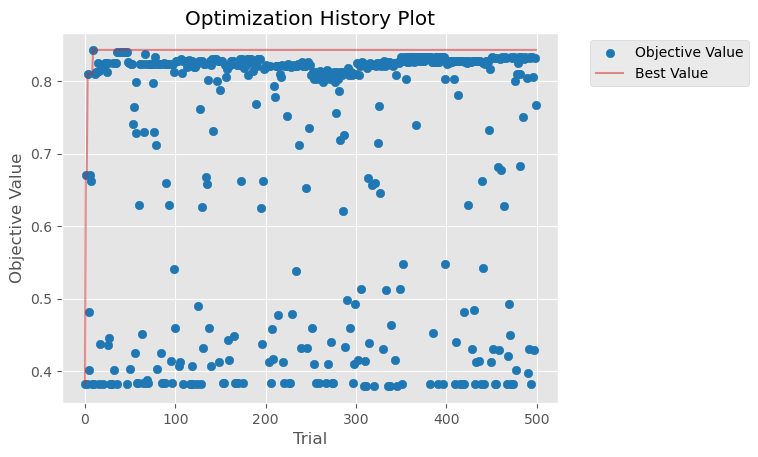

In [155]:
plot_optimization_history(study_svm);

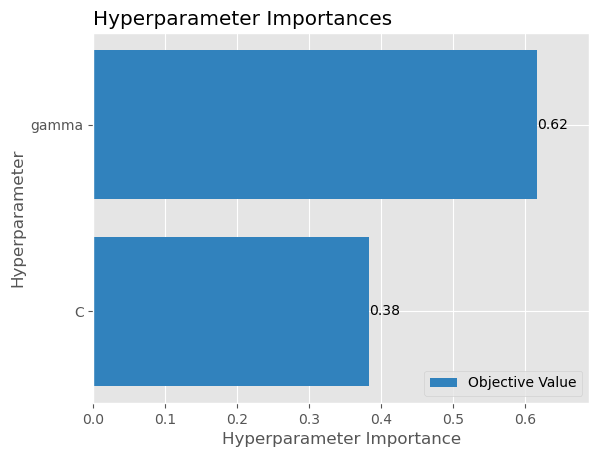

In [156]:
plot_param_importances(study_svm);

In [157]:
detailed_objective_svm_cv(study_svm.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,TP,164.900000,5.743595
1,TN,86.300000,2.584140
2,FP,27.100000,4.677369
3,FN,18.800000,1.988858
4,Accuracy,0.845508,0.018325
5,Precision,0.858842,0.024397
6,Sensitivity,0.897505,0.011970
7,Specificity,0.761930,0.032807
8,F1 score,0.877621,0.016218
9,F1 score (weighted),0.844255,0.018865


In [158]:
mat_met_svm_test['ave'] = mat_met_svm_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_svm_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave
0,TP,328.000000,319.000000,324.000000,327.000000,336.000000,326.000000,340.000000,329.000000,323.000000,325.000000,327.700000
1,TN,164.000000,181.000000,169.000000,172.000000,181.000000,181.000000,163.000000,172.000000,179.000000,163.000000,172.500000
2,FP,63.000000,56.000000,60.000000,66.000000,57.000000,53.000000,50.000000,56.000000,50.000000,64.000000,57.500000
3,FN,40.000000,39.000000,42.000000,30.000000,21.000000,35.000000,42.000000,38.000000,43.000000,43.000000,37.300000
4,Accuracy,0.826891,0.840336,0.828571,0.838655,0.868908,0.852101,0.845378,0.842017,0.843697,0.820168,0.840672
5,Precision,0.838875,0.850667,0.843750,0.832061,0.854962,0.860158,0.871795,0.854545,0.865952,0.835476,0.850824
6,Sensitivity,0.891304,0.891061,0.885246,0.915966,0.941176,0.903047,0.890052,0.896458,0.882514,0.883152,0.897998
7,Specificity,0.722500,0.763700,0.738000,0.722700,0.760500,0.773500,0.765300,0.754400,0.781700,0.718100,0.750040
8,F1 score,0.864295,0.870396,0.864000,0.872000,0.896000,0.881081,0.880829,0.875000,0.874154,0.858653,0.873641
9,F1 score (weighted),0.824895,0.839218,0.827122,0.835927,0.866691,0.850942,0.844700,0.840661,0.843225,0.818302,0.839168


In [159]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)


Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_svm=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_svm = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )


        #learn
        
        optimizedCV_svm.fit(X_train,y_train)
                          
                  
        #print(test_idx)
        y_pred_optimized_svm = optimizedCV_svm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_svm': y_pred_optimized_svm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        
        conf_matrix = confusion_matrix(y_test, y_pred_optimized_svm)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        Accuracy_outer.append(accuracy_score(y_test, y_pred_optimized_svm))
        Precision_outer.append(precision_score(y_test, y_pred_optimized_svm))
        Sensitivity_outer.append(recall_score(y_test, y_pred_optimized_svm))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test, y_pred_optimized_svm))
        f1_scores_W_outer.append(f1_score(y_test, y_pred_optimized_svm, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test, y_pred_optimized_svm, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test, y_pred_optimized_svm))
        MCC_outer.append(matthews_corrcoef(y_test, y_pred_optimized_svm))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test, y_pred_optimized_svm))
        
    data_svm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_svm['y_test' + str(i)] = data_inner['y_test']
    data_svm['y_pred_svm' + str(i)] = data_inner['y_pred_svm']
   # data_svm['correct' + str(i)] = correct_value
   # data_svm['pred' + str(i)] = y_pred_optimized_svm

mat_met_optimized_svm = pd.DataFrame({'Metric':['Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [ np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 

mat_met_optimized_svm


,Metric,Value (average),Value (std)
0,Accuracy,0.851902,0.015053
1,Precision,0.863626,0.019244
2,Sensitivity,0.903607,0.016634
3,Specificity,0.768052,0.036698
4,F1 score,0.882952,0.011668
5,F1 score (weighted),0.850615,0.015471
6,F1 score (macro),0.840342,0.017244
7,Balanced Accuracy,0.835827,0.018408
8,MCC,0.683030,0.033972
9,NPV,0.831068,0.027410


In [160]:
#cross valide using this optimized SVC 
svm_baseline_CVscore = cross_val_score(svm_clf, X, Y, cv=10, scoring="f1_macro")
#cv_svm_opt_testSet = cross_val_score(optimized_svm, X, Y, cv=10, scoring="f1_macro")
cv_svm_opt = cross_val_score(optimizedCV_svm, X, Y, cv=10, scoring="f1_macro")
print("SVM baseline model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(svm_baseline_CVscore), np.std(svm_baseline_CVscore, ddof=1)))
#print("SVM optimized model (tested on Y_te) f1_score %0.4f with a standard deviation of %0.4f" % (svm_baseline_CVscore.mean(), svm_baseline_CVscore.std()))
print("SVM optimized model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_svm_opt), np.std(cv_svm_opt, ddof=1)))

SVM baseline model f1_score 0.8302 with a standard deviation of 0.0169
SVM optimized model f1_score 0.8372 with a standard deviation of 0.0192


In [161]:
# save the modesls, both the one with optimized hyperparameters and the initial one
joblib.dump(svm_clf, "OUTPUT/svm_clf.joblib")
joblib.dump(optimizedCV_svm, "OUTPUT/optimizedCV_svm_clf.joblib")

['OUTPUT/optimizedCV_svm_clf.joblib']

In [163]:
# save the evaluation results of Optimized and saved models to an Excel file

with pd.ExcelWriter("OUTPUT/TestSet_EvaluationResults.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_rf_test.to_excel(writer, sheet_name="RF", )
    mat_met_lgbm_test.to_excel(writer, sheet_name="LGBM", )
    mat_met_xgb_test.to_excel(writer, sheet_name="XGB", )
    mat_met_knn_test.to_excel(writer, sheet_name="KNN", )
    mat_met_svm_test.to_excel(writer, sheet_name="SVM", )
   

In [164]:
# save the evaluation results of Optimized and saved models to an Excel file

with pd.ExcelWriter("OUTPUT/EvaluationResults.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_optimized_rf.to_excel(writer, sheet_name="RF", )
    mat_met_optimized_lgbm.to_excel(writer, sheet_name="LGBM", )
    mat_met_optimized_xgb.to_excel(writer, sheet_name="XGB", )
    mat_met_optimized_knn.to_excel(writer, sheet_name="KNN", )
    mat_met_optimized_svm.to_excel(writer, sheet_name="SVM", )